In [1]:
%matplotlib inline

import pandas as pd
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as py
from plotly.subplots import make_subplots
import numpy as np

py.init_notebook_mode()

In [2]:
platforms = ["Pitchfork", "Guardian", "NME", "Spectrum"]
dfs = {platform: 
       pd.read_hdf("C:\\Users\\tommy\\OneDrive\\University\\Year 3\\Third Year Project\\Platform Album Data\\review_data_final.h5", key=platform) for platform in platforms}

In [3]:
# Exploring score missing data

for platform, df in dfs.items():
    
    df.loc[:, "Scores"] = pd.to_numeric(df.loc[:, "Scores"])

for platform in platforms:
    
    print(platform + ": ", dfs[platform].loc[dfs[platform]["Scores"] == -1].shape[0])

Pitchfork:  0
Guardian:  0
NME:  0
Spectrum:  330


All fine except spectrum which seems to be missing a lot of scores. I have cross validated this with the urls and the reviews do not have a listed score on the website so this is no error. We therefore have much less data to work with with regard to spectrum.

In [4]:
# Exploring genre missing data

for platform in ["Guardian", "Pitchfork"]:
    
    print(platform + ": ", dfs[platform].loc[dfs[platform]["Genres"] == "NA"])

Guardian:  Empty DataFrame
Columns: [Platform, Artist, Album, Text, Scores, Genres, Url]
Index: []
Pitchfork:  Empty DataFrame
Columns: [Platform, Artist, Album, Text, Scores, Genres, Url]
Index: []


In [5]:
g_df = dfs["Guardian"]

len(g_df["Genres"].iloc[4])

1

In [6]:
def count_missing(x):
    
    if len(x) == 1:
        return 1
    
    else:
        return 0
    
g_df["Genres"].apply(count_missing).sum()

940

Since all lists are of length 1, we get the first element then repeat

In [7]:
g_df["Genres"] = g_df["Genres"].apply(lambda x: x[0])

g_df["Genres"]

0           electronicmusic, popandrock
1                            popandrock
2           popandrock, electronicmusic
3             popandrock, yeahyeahyeahs
4                                      
                     ...               
935                            pjharvey
936    hip-hop, popandrock, nicki-minaj
937                          popandrock
938                          popandrock
939                             hip-hop
Name: Genres, Length: 940, dtype: object

In [8]:
len(g_df["Genres"].iloc[4])

0

Now we can count missing

In [9]:
g_df["Genres"].apply(lambda x: len(x) == 0).sum()

77

There are 77 missing genres. This is only just less than 10% of the data so we will just remove these when analysing differences in genre classification.

In [10]:
# Let's take a look at what genres we have

g_df["Genres"].unique()

array(['electronicmusic, popandrock', 'popandrock',
       'popandrock, electronicmusic', 'popandrock, yeahyeahyeahs', '',
       'australian-music, rap', 'popandrock, r-and-b, dance-music',
       'popandrock, r-and-b, rap',
       'popandrock, dance-music, electronicmusic, dua-lipa, pharrellwilliams, ure/justin-timberlake',
       'popandrock, indie, experimental-music',
       'experimental-music, popandrock, indie',
       'popandrock, rap, dance-music, electronicmusic',
       'popandrock, anohni, sia-furler', 'americana, country',
       'arcadefire, popandrock, indie',
       'let-s-eat-grandma, electronicmusic, popandrock, indie',
       'popandrock, jazz', 'indie, punk', 'dance-music',
       'popandrock, indie', 'rosalia, the-weeknd, mia, hip-hop',
       'popandrock, christine-and-the-queens, caroline-polachek',
       'psychedelia, popandrock', 'hip-hop',
       'rap, odd-future-wolf-gang-kill-them-all', 'punk',
       'popandrock, phoebe-bridgers, ed-sheeran, snow-patrol',

Unfortunately this looks like time for a manual list of relevant genres. Oh dear.

We can at least make life a bit easier by splitting each into a list of genres rather than treating combinations as unique

In [11]:
g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(lambda x: x.split(", "))

g_df.loc[:, "Genres"]

0           [electronicmusic, popandrock]
1                            [popandrock]
2           [popandrock, electronicmusic]
3             [popandrock, yeahyeahyeahs]
4                                      []
                      ...                
935                            [pjharvey]
936    [hip-hop, popandrock, nicki-minaj]
937                          [popandrock]
938                          [popandrock]
939                             [hip-hop]
Name: Genres, Length: 940, dtype: object

In [12]:
genres_list = []

for genres in g_df["Genres"]:
    
    for genre in genres:
        
        if genre not in genres_list:
            genres_list.append(genre)
            
genres_list

['electronicmusic',
 'popandrock',
 'yeahyeahyeahs',
 '',
 'australian-music',
 'rap',
 'r-and-b',
 'dance-music',
 'dua-lipa',
 'pharrellwilliams',
 'ure/justin-timberlake',
 'indie',
 'experimental-music',
 'anohni',
 'sia-furler',
 'americana',
 'country',
 'arcadefire',
 'let-s-eat-grandma',
 'jazz',
 'punk',
 'rosalia',
 'the-weeknd',
 'mia',
 'hip-hop',
 'christine-and-the-queens',
 'caroline-polachek',
 'psychedelia',
 'odd-future-wolf-gang-kill-them-all',
 'phoebe-bridgers',
 'ed-sheeran',
 'snow-patrol',
 'gorillaz',
 'blur',
 'disco',
 'bts',
 '/selena-gomez',
 'metal',
 'andstyle/celebrity',
 'soul',
 'bruno-mars',
 'leon-bridges',
 'lil-wayne',
 'megan-thee-stallion',
 'stevie-nicks',
 'black-midi',
 'taylor-swift',
 'ety/youngpeople',
 'andstyle/relationships',
 'andstyle/women',
 'london-grammar',
 'dry-cleaning',
 'loretta-lynn',
 'ety/older-people',
 'd/feminism',
 'black-country-new-road',
 'folk',
 'dave-grohl',
 's/poetry',
 'arlo-parks',
 'thebeatles',
 'mark-ronson

In [13]:
# Manually reviewed

guardian_genres = ['electronicmusic',
 'popandrock',
 'australian-music',
 'rap',
 'r-and-b',
 'dance-music',
 'indie',
 'experimental-music',
 'americana',
 'country',
 'jazz',
 'punk',
 'hip-hop',
 'psychedelia',
 'disco',
 'metal',
 'soul',
 'folk',
 'clubs',
 'k-pop',
 'grime',
 'motown',
 'dubstep',
 'blues',
 'reggae',
 'classical-music-and-opera',
 'opera',
]

In [14]:
def filter_guardian(x):
    
    remove = []
    
    for genre in x:
        
        if genre not in guardian_genres:
            remove.append(genre)
            
    for genre in remove:
        x.remove(genre)
        
    if not x:
        x = ["NA"]
            
    return x

g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(filter_guardian)
g_df = g_df.explode("Genres")

g_df.loc[:, "Genres"].unique()

array(['electronicmusic', 'popandrock', 'NA', 'australian-music', 'rap',
       'r-and-b', 'dance-music', 'indie', 'experimental-music',
       'americana', 'country', 'jazz', 'punk', 'hip-hop', 'psychedelia',
       'disco', 'metal', 'soul', 'folk', 'clubs', 'k-pop', 'grime',
       'motown', 'dubstep', 'blues', 'reggae',
       'classical-music-and-opera', 'opera'], dtype=object)

In [15]:
g_df.loc[g_df["Genres"] == "NA"].shape[0]

126

In [16]:
g_df.loc[:, "Genres"].value_counts()

popandrock                   609
indie                        209
NA                           126
electronicmusic               99
dance-music                   51
hip-hop                       51
r-and-b                       40
rap                           39
punk                          38
soul                          27
folk                          24
experimental-music            23
psychedelia                   19
americana                     13
country                       11
metal                         11
jazz                           9
clubs                          6
dubstep                        4
blues                          4
disco                          3
k-pop                          2
reggae                         2
australian-music               1
grime                          1
motown                         1
classical-music-and-opera      1
opera                          1
Name: Genres, dtype: int64

In [17]:
def group_small(x):
    
    if x in ["clubs", "dubstep", "blues", "disco", "k-pop", "reggae", "australian-music", "grime", "motown", "classical-music-and-opera", "opera"]:
        
        x = "Other"
        
    return x

g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(group_small)

In [18]:
g_genres = g_df.loc[:, "Genres"].unique()

g_genres

array(['electronicmusic', 'popandrock', 'NA', 'Other', 'rap', 'r-and-b',
       'dance-music', 'indie', 'experimental-music', 'americana',
       'country', 'jazz', 'punk', 'hip-hop', 'psychedelia', 'metal',
       'soul', 'folk'], dtype=object)

In [19]:
g_df.loc[g_df["Genres"] == "Other"]

Platform               Artist                        Album  \
6    Guardian      sampa the great            as above so below   
56   Guardian                 abba                       voyage   
117  Guardian        roisin murphy               roisin machine   
132  Guardian          jessie ware        what's your pleasure?   
142  Guardian            lady gaga                   chromatica   
169  Guardian          tame impala                the slow rush   
243  Guardian             slowthai  nothing great about britain   
264  Guardian          marvin gaye               you're the man   
283  Guardian          james blake                  assume form   
284  Guardian          james blake                  assume form   
360  Guardian               grimes                   art angels   
374  Guardian           disclosure                      caracal   
437  Guardian       alabama shakes              sound and color   
633  Guardian             cut copy               free your mind   
695  Guardian               austra                      olympia   
721  Guardian           snoop lion                 reincarnated   
722  Guardian           snoop lion                 reincarnated   
730  Guardian          james blake                    overgrown   
756  Guardian             darkstar            news from nowhere   
827  Guardian          jessie ware                     devotion   
863  Guardian  simian mobile disco                   unpatterns   
864  Guardian         damon albarn                       dr dee   
865  Guardian         damon albarn                       dr dee   
879  Guardian       alabama shakes               boys and girls   
880  Guardian       alabama shakes               boys and girls   
909  Guardian             lambchop                         mr m   

                                                  Text  Scores Genres  \
6     Sampa Tembo is no longer answering to Austral...       4  Other   
56    After 40 years, the makers of once-sparkling ...       2  Other   
117  Pop outsider and lockdown living-room star Mur...       4  Other   
132  Without the burden of reinvention, Ware’s four...       4  Other   
142   Returning to the sound of her maximalist elec...       4  Other   
169  Kevin Parker shifts further away from his psyc...       4  Other   
243  On his debut album, the Northampton rapper swe...       5  Other   
264  Remixed and repackaged collection finds a trou...       3  Other   
283   A love letter to his partner brimming with gu...       3  Other   
284   Blake is clearly in a good place, unexpectedl...       4  Other   
360  . Unless you explicitly set out to play authen...       3  Other   
374  . It begins not with a banger, but with a sult...       3  Other   
437  . Powerhouses don’t come much more energised t...       4  Other   
633  . This is an homage to the music of the second...       2  Other   
695  . Sad dance music is an art, and few do it wel...       4  Other   
721  . For all his erstwhile gin, juice and pimpin'...       2  Other   
722   Despite featuring Miley Cyrus, the drummer fr...       2  Other   
730  . As album number two begins to trickles in, i...       3  Other   
756  . Those familiar with Darkstar's signature sin...       4  Other   
827   Jessie Ware doesn't seem to be gunning for po...       4  Other   
863  . Jas Shaw and James Ford have what might be c...       4  Other   
864  . Any casual fans wondering what that Gorillaz...       3  Other   
865  . It starts with birdsong and a church bell, a...       4  Other   
879  . Alabama Shakes are a double rarity in being ...       4  Other   
880  . It's not difficult to see why the Alabama Sh...       3  Other   
909  . Kurt Wagner has addressed loss, death and th...       4  Other   

                                                   Url  
6    https://www.theguardian.com/music/2022/sep/09/...  
56   https://www.theguardian.com/music/2021/nov/05/...  
117  https://www.theguardian.com/music/2020/sep/24/.

In [20]:
def remove_na(x):
    
    if len(x) > 1 and "NA" in x:
        x.remove("NA")
        
    return x

g_df_genre = g_df.loc[:, ["Artist", "Album", "Scores", "Genres"]]

g_df_genre = g_df_genre.groupby(by=["Artist", "Album"])["Genres"].aggregate(lambda x: ", ".join(tuple(x)))
g_df_genre = g_df_genre.reset_index()

g_df_genre.loc[:, "Genres"] = g_df_genre.loc[:, "Genres"].apply(lambda x: pd.Series(x.split(", ")).unique())
g_df = pd.merge(g_df.loc[:, g_df.columns != "Genres"], g_df_genre.loc[:, ["Artist", "Album", "Genres"]],
                how="left", on=["Artist", "Album"])

g_df["Genres"] = g_df["Genres"].apply(lambda x: " ".join(x))
g_df = g_df.drop_duplicates()

g_df = g_df.reset_index(drop=True)
g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(lambda x: x.split(" "))
g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(remove_na)

g_df = g_df.explode("Genres").reset_index(drop=True)
g_df.head(5)

Platform     Artist                 Album  \
0  Guardian  brian eno  foreverandevernomore   
1  Guardian  brian eno  foreverandevernomore   
2  Guardian    shygirl                 nymph   
3  Guardian      bjork               fossora   
4  Guardian      bjork               fossora   

                                                Text  Scores  \
0  The producer contemplates the future of the pl...       4   
1  The producer contemplates the future of the pl...       4   
2  British rapper, DJ and singer-songwriter Blane...       4   
3  The pop auteur’s 10th album deals with the dea...       4   
4  The pop auteur’s 10th album deals with the dea...       4   

                                                 Url           Genres  
0  https://www.theguardian.com/music/2022/oct/16/...  electronicmusic  
1  https://www.theguardian.com/music/2022/oct/16/...       popandrock  
2  https://www.theguardian.com/music/2022/oct/02/...       popandrock  
3  https://www.theguardian.com/music/2022/oct/01/...       popandrock  
4  https://www.theguardian.com/music/2022/oct/01/...  electronicmusic

In [21]:
g_df.loc[g_df["Genres"] == "Other"].iloc[:5, :]

Platform           Artist                  Album  \
8    Guardian  sampa the great      as above so below   
90   Guardian             abba                 voyage   
92   Guardian             abba                 voyage   
185  Guardian    roisin murphy         roisin machine   
211  Guardian      jessie ware  what's your pleasure?   

                                                  Text  Scores  \
8     Sampa Tembo is no longer answering to Austral...       4   
90   The return of the Swedish super troupers has p...       3   
92    After 40 years, the makers of once-sparkling ...       2   
185  Pop outsider and lockdown living-room star Mur...       4   
211  The singer-songwriter swaps luxe pop for the e...       4   

                                                   Url Genres  
8    https://www.theguardian.com/music/2022/sep/09/...  Other  
90   https://www.theguardian.com/music/2021/nov/06/...  Other  
92   https://www.theguardian.com/music/2021/nov/05/...  Other  
185  https://www.theguardian.com/music/2020/sep/24/...  Other  
211  https://www.theguardian.com/music/2020/jun/28/...  Other

In [22]:
g_df.loc[:, "Genres"].value_counts()

popandrock            712
indie                 282
electronicmusic       133
NA                     74
hip-hop                71
dance-music            68
r-and-b                57
punk                   53
rap                    52
soul                   36
Other                  35
folk                   34
experimental-music     33
psychedelia            26
americana              21
country                15
metal                  15
jazz                   12
Name: Genres, dtype: int64

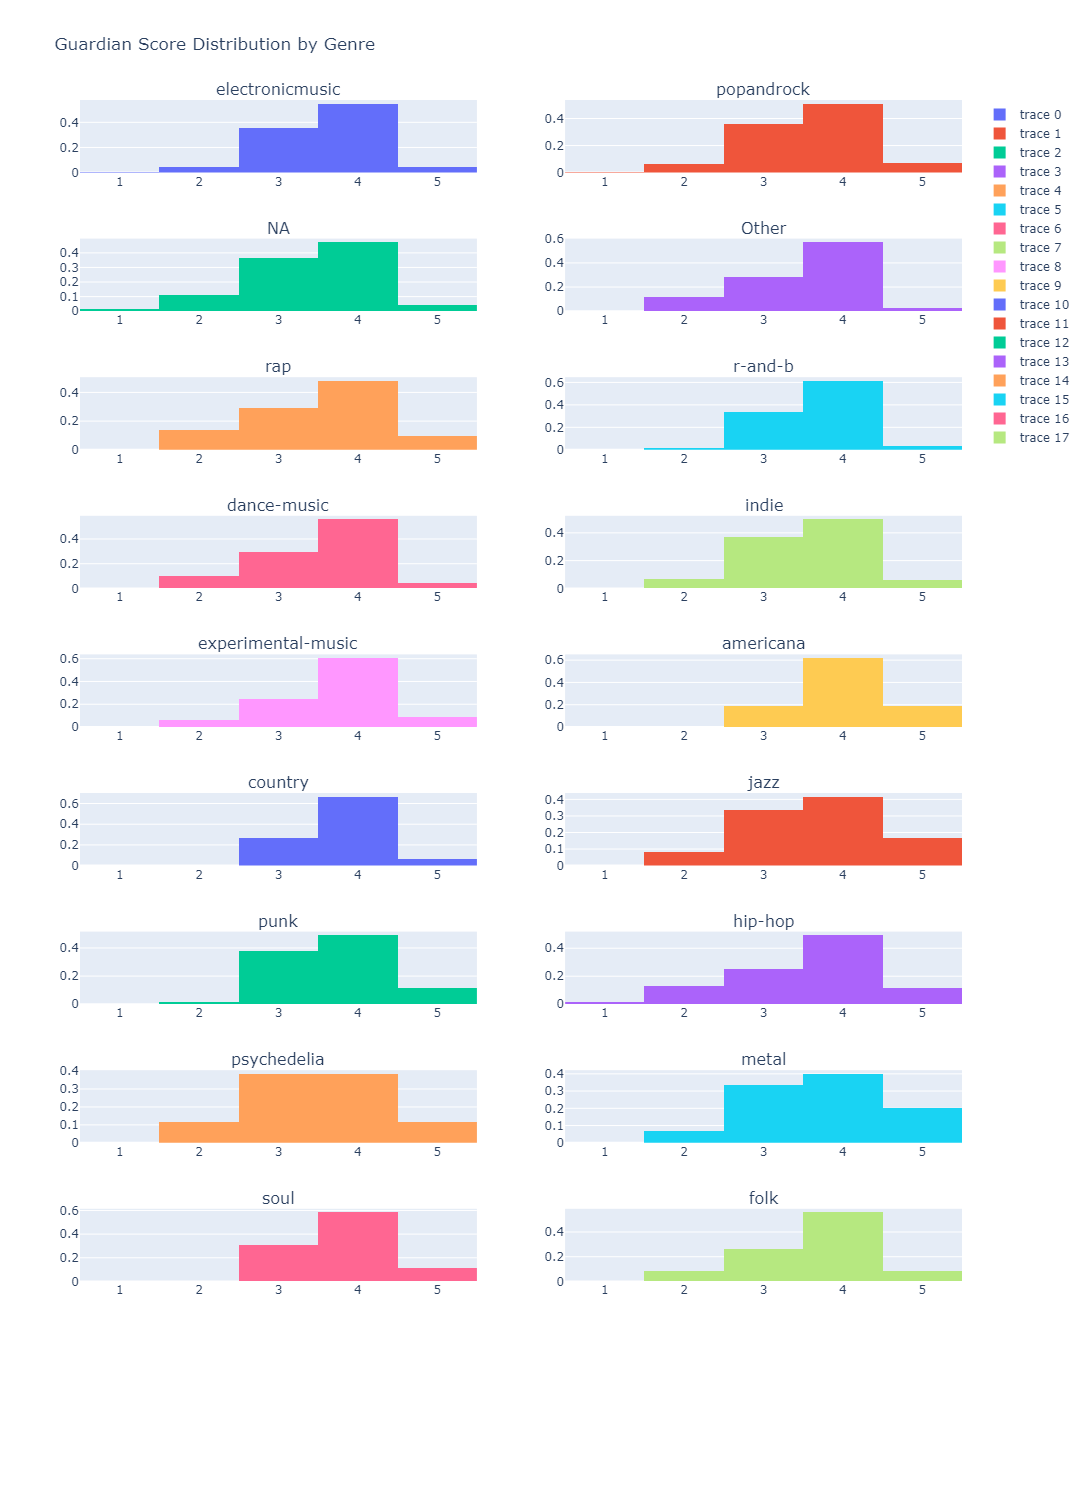

In [23]:
fig = make_subplots(rows=10, cols=2, subplot_titles=g_genres)

for i in range(1, 11):
    for j in range(1, 3):
        
        index = 2 * (i - 1) + j - 1
        
        if index >= len(g_genres):
            break
        
        genre = g_genres[index]
        
        fig.add_trace(go.Histogram(x=g_df.loc[g_df["Genres"] == genre, "Scores"],
                                   xbins={"start": 0.5,
                                          "end": 5.5,
                                          "size": 1},
                                  histnorm="probability density"), row=i, col=j)
                            
fig.update_layout(title_text="Guardian Score Distribution by Genre", height=1500)
fig.update_xaxes(range=[0.5, 5.5])

In [24]:
# Pitchfork genre

pf_df = dfs["Pitchfork"]

def find_second_last(string, char):
    
    count = 0
    i = len(string)
    
    for c in string[::-1]:
        i -= 1
        
        if c == char:
            count += 1
            
            if count == 2:
                return i
            
    return -1

pf_df["Genres"].apply(lambda x: find_second_last(x, ",")).max()
                

64

All genres have had a date added so remove based on the second last comma

In [25]:
def remove_second_last(string, char):
    
    index = find_second_last(string, char)
    
    return string[:index]

pf_df["Genres"] = pf_df["Genres"].apply(lambda x: remove_second_last(x, ","))
    
pf_df["Genres"]

0                           Electronic, Verve / UMC
1                         Electronic, Because Music
2      Electronic / Pop/R&B, One Little Independent
3                           Rock, Secretly Canadian
4                                      Rock, Domino
                           ...                     
935                  Rock, Vagrant / Island Def Jam
936                      Rap, Def Jam / Roc-A-Fella
937                                    Rock, Domino
938                                    Rock, Domino
939                                Rap, Roc-A-Fella
Name: Genres, Length: 940, dtype: object

In [26]:
pf_df["Genres"].unique()[:5]

array(['Electronic, Verve / UMC', 'Electronic, Because Music',
       'Electronic / Pop/R&B, One Little Independent',
       'Rock, Secretly Canadian', 'Rock, Domino'], dtype=object)

In [27]:
# Since pitchfork also collected label data we will remove that also

pf_df["Genres"] = pf_df["Genres"].apply(lambda x: x[:x.find(",")])

In [28]:
pf_df["Genres"].unique()

array(['Electronic', 'Electronic / Pop/R&B', 'Rock', 'Pop/R&B', 'Rap',
       'Pop/R&B / Electronic', 'Pop/R&B / Rap', 'Experimental / Rock',
       'Folk/Country', 'Experimental', 'Electronic / Jazz', 'Metal',
       'Pop/R&B / Rock', 'Electronic / Rock', 'Rock / Rap',
       'Rock / Metal', 'Global', 'Global / Pop/R&B',
       'Rock / Experimental', '4A', 'Spinefar', 'Domin', 'Metal / Rock',
       'AT', 'Jazz / Pop/R&B',
       'RCA / Vice / Mad Decent / Berhane Sound Syste',
       'Electronic / Experimental', 'Captured Track', 'Fir',
       'Jazz / Rock', 'Experimental / Rap', "Honest Jon'"], dtype=object)

Doesn't that look lovely. Except it doesn't because there are still a fair few labels in there that have no genre.

In [29]:
pf_df.loc[pf_df["Genres"].isin(["4A", "Global", "Spinefar", "Domin", "AT", "RCA / Vice / Mad Decent / Berhane Sound Syste", "Captured Track", "Fir",
                              "Honest Jon'"])]

Platform                     Artist                      Album  \
399  Pitchfork             omar souleyman               bahdeni nami   
505  Pitchfork   scott walker + sunn o)))                     soused   
506  Pitchfork   scott walker + sunn o)))                     soused   
518  Pitchfork            electric wizard                time to die   
576  Pitchfork     the amazing snakeheads        amphetamine ballads   
634  Pitchfork             omar souleyman                  wenu wenu   
685  Pitchfork                   hebronix                     unreal   
721  Pitchfork                 snoop lion               reincarnated   
722  Pitchfork                 snoop lion               reincarnated   
749  Pitchfork               caitlin rose                the standin   
831  Pitchfork                  holograms                  holograms   
845  Pitchfork           mission of burma                    unsound   
881  Pitchfork  rocket juice and the moon  rocket juice and the moon   
882  Pitchfork  rocket juice and the moon  rocket juice and the moon   

                                                  Text  Scores  \
399  Syrian singer Omar Souleyman's first proper st...     6.2   
505  The pairing of Scott Walker and Sunn O)))  is ...     7.4   
506  The pairing of Scott Walker and Sunn O)))  is ...     7.4   
518  The latest effort from England’s reigning doom...     7.9   
576  Short bursts of anger snap into place in the d...     6.4   
634  Syrian singer Omar Souleyman’s Wenu Wenu is te...     7.2   
685  The ex-Yuck frontman Daniel Blumberg's first a...     6.7   
721  Snoop Dogg's dalliance with reggae was documen...     5.0   
722  Snoop Dogg's dalliance with reggae was documen...     5.0   
749  The Nashville singer-songwriter Caitlin Rose s...     7.0   
831  On their self-titled debut, the Stockholm band...     7.1   
845  A decade into their second career, Mission of ...     7.7   
881  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1   
882  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1   

                                            Genres  \
399                                         Global   
505                                             4A   
506                                             4A   
518                                       Spinefar   
576                                          Domin   
634                                         Global   
685                                             AT   
721  RCA / Vice / Mad Decent / Berhane Sound Syste   
722  RCA / Vice / Mad Decent / Berhane Sound Syste   
749                                             AT   
831                                 Captured Track   
845                                            Fir   
881                                    Honest Jon'   
882                                    Honest Jon'   

                                                   Url  
399  https://www.pitchfork.com/reviews/albums/20830...  
505  https://www.pitchfork.com/reviews/albums/19946...  
506  https://www.pitchfork.com/reviews/albums/19946...  
518  https://www.pitchfork.com/reviews/albums/19622...  
576  https://www.pitchfork.com/reviews/albums/19640...  
634  https://www.pitchfork.com/reviews/albums/18665...  
685  https://www.pitchfork.com/reviews/albums/18292...  
721  https://www.pitchfork.com/reviews/albums/17920...  
722  https://www.pitchfork.com/reviews/albums/17920...  
749  https://www.pitchfork.com/reviews/albums/17796...  
831  https://www.pitchfork.com/reviews/albums/16901...  
845  https://www.pitchfork.com/reviews/albums/16815...  
881  https://www.pitchfork.com/reviews/albums/16365...  
882  https://www.pitchfork.com/reviews/albums/16365...

Upon spot checking the only legitimate genre of the above list is global so we will set the rest to NA as they have no genre.

In [30]:
pf_df.loc[pf_df["Genres"].isin(["4A", "Spinefar", "Domin", "AT", "Captured Track", "Fir",
                              "Honest Jon'", "RCA / Vice / Mad Decent / Berhane Sound Syste"]), "Genres"] = "NA"

pf_df.loc[pf_df["Genres"] == "NA"]

Platform                     Artist                      Album  \
505  Pitchfork   scott walker + sunn o)))                     soused   
506  Pitchfork   scott walker + sunn o)))                     soused   
518  Pitchfork            electric wizard                time to die   
576  Pitchfork     the amazing snakeheads        amphetamine ballads   
685  Pitchfork                   hebronix                     unreal   
721  Pitchfork                 snoop lion               reincarnated   
722  Pitchfork                 snoop lion               reincarnated   
749  Pitchfork               caitlin rose                the standin   
831  Pitchfork                  holograms                  holograms   
845  Pitchfork           mission of burma                    unsound   
881  Pitchfork  rocket juice and the moon  rocket juice and the moon   
882  Pitchfork  rocket juice and the moon  rocket juice and the moon   

                                                  Text  Scores Genres  \
505  The pairing of Scott Walker and Sunn O)))  is ...     7.4     NA   
506  The pairing of Scott Walker and Sunn O)))  is ...     7.4     NA   
518  The latest effort from England’s reigning doom...     7.9     NA   
576  Short bursts of anger snap into place in the d...     6.4     NA   
685  The ex-Yuck frontman Daniel Blumberg's first a...     6.7     NA   
721  Snoop Dogg's dalliance with reggae was documen...     5.0     NA   
722  Snoop Dogg's dalliance with reggae was documen...     5.0     NA   
749  The Nashville singer-songwriter Caitlin Rose s...     7.0     NA   
831  On their self-titled debut, the Stockholm band...     7.1     NA   
845  A decade into their second career, Mission of ...     7.7     NA   
881  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1     NA   
882  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1     NA   

                                                   Url  
505  https://www.pitchfork.com/reviews/albums/19946...  
506  https://www.pitchfork.com/reviews/albums/19946...  
518  https://www.pitchfork.com/reviews/albums/19622...  
576  https://www.pitchfork.com/reviews/albums/19640...  
685  https://www.pitchfork.com/reviews/albums/18292...  
721  https://www.pitchfork.com/reviews/albums/17920...  
722  https://www.pitchfork.com/reviews/albums/17920...  
749  https://www.pitchfork.com/reviews/albums/17796...  
831  https://www.pitchfork.com/reviews/albums/16901...  
845  https://www.pitchfork.com/reviews/albums/16815...  
881  https://www.pitchfork.com/reviews/albums/16365...  
882  https://www.pitchfork.com/reviews/albums/16365...

In [31]:
pf_df.loc[:, "Genres"].unique()

array(['Electronic', 'Electronic / Pop/R&B', 'Rock', 'Pop/R&B', 'Rap',
       'Pop/R&B / Electronic', 'Pop/R&B / Rap', 'Experimental / Rock',
       'Folk/Country', 'Experimental', 'Electronic / Jazz', 'Metal',
       'Pop/R&B / Rock', 'Electronic / Rock', 'Rock / Rap',
       'Rock / Metal', 'Global', 'Global / Pop/R&B',
       'Rock / Experimental', 'NA', 'Metal / Rock', 'Jazz / Pop/R&B',
       'Electronic / Experimental', 'Jazz / Rock', 'Experimental / Rap'],
      dtype=object)

Much better.

In [32]:
def pitchfork_split(x):
    
    x = x.split(" / ")
    
    return [e.strip() for e in x]

pf_df.loc[:, "Genres"] = pf_df.loc[:, "Genres"].apply(pitchfork_split)


In [33]:
pf_df = pf_df.explode("Genres")

In [34]:
pf_df

Platform           Artist                              Album  \
0    Pitchfork        brian eno               foreverandevernomore   
1    Pitchfork          shygirl                              nymph   
2    Pitchfork            bjork                            fossora   
2    Pitchfork            bjork                            fossora   
3    Pitchfork  yeah yeah yeahs                       cool it down   
..         ...              ...                                ...   
935  Pitchfork        pj harvey                  let england shake   
936  Pitchfork       kanye west  my beautiful dark twisted fantasy   
937  Pitchfork   arctic monkeys                             humbug   
938  Pitchfork   arctic monkeys                             humbug   
939  Pitchfork       kanye west                808s and heartbreak   

                                                  Text  Scores      Genres  \
0    Confronting the climate crisis and the prospec...     7.5  Electronic   
1    Sensuous, funny, and smartly produced, the Lon...     8.0  Electronic   
2    With her 10th album, Björk is grounded back on...     8.4  Electronic   
2    With her 10th album, Björk is grounded back on...     8.4     Pop/R&B   
3    The trio’s first album in nine years ushers in...     7.4        Rock   
..                                                 ...     ...         ...   
935  The always-unpredictable singer-songwriter ret...     8.8        Rock   
936  Kanye's big year culminates in an LP that feel...    10.0         Rap   
937  The Arctics expand their sound with the help o...     7.2        Rock   
938  The Arctics expand their sound with the help o...     7.2        Rock   
939   Poor Kanye West. The guy was already a ball o...     7.6         Rap   

                                                   Url  
0    https://www.pitchfork.com/reviews/albums/brian...  
1    https://www.pitchfork.com/reviews/albums/shygi...  
2    https://www.pitchfork.com/reviews/albums/bjork...  
2    https://www.pitchfork.com/reviews/albums/bjork...  
3    https://www.pitchfork.com/reviews/albums/yeah-...  
..                                                 ...  
935  https://www.pitchfork.com/reviews/albums/15120...  
936  https://www.pitchfork.com/reviews/albums/14880...  
937  https://www.pitchfork.com/reviews/albums/13374...  
938  https://www.pitchfork.com/reviews/albums/13374...  
939  https://www.pitchfork.com/reviews/albums/12498...  

[1033 rows x 7 columns]

In [35]:
pf_genres = pf_df.loc[:, "Genres"].unique()
len(pf_genres)

10

In [36]:
pf_summ_genre = pf_df.groupby("Genres").agg({"Scores": ["mean", "std"]})
pf_summ_genre["Count"] = pf_df.groupby("Genres").size()
pf_summ_genre["% of Albums"] = pf_summ_genre["Count"] * 100 / 940
round(pf_summ_genre, 2)

Scores       Count % of Albums
               mean   std                  
Genres                                     
Electronic     7.27  1.12   134       14.26
Experimental   7.69  0.92    42        4.47
Folk/Country   7.61  1.00    28        2.98
Global         7.02  0.53     8        0.85
Jazz           6.60  1.44     3        0.32
Metal          7.07  0.88    10        1.06
NA             6.65  0.96    12        1.28
Pop/R&B        7.32  1.05   206       21.91
Rap            7.45  1.25    71        7.55
Rock           7.26  1.13   519       55.21

In [37]:
g_summ_genre = g_df.copy()
g_summ_genre.loc[:, "Scores"] = g_summ_genre.loc[:, "Scores"] * 2
g_summ_genre = g_summ_genre.groupby("Genres").agg({"Scores": ["mean", "std"]})
g_summ_genre["Count"] = g_df.groupby("Genres").size()
g_summ_genre["% of Albums"] = g_summ_genre["Count"] * 100 / 940
round(g_summ_genre, 2)

Scores       Count % of Albums
                     mean   std                  
Genres                                           
NA                   6.84  1.59    74        7.87
Other                7.03  1.48    35        3.72
americana            8.00  1.26    21        2.23
country              7.60  1.12    15        1.60
dance-music          7.09  1.48    68        7.23
electronicmusic      7.16  1.38   133       14.15
experimental-music   7.45  1.44    33        3.51
folk                 7.29  1.55    34        3.62
hip-hop              7.13  1.81    71        7.55
indie                7.11  1.44   282       30.00
jazz                 7.33  1.78    12        1.28
metal                7.47  1.77    15        1.60
popandrock           7.17  1.44   712       75.74
psychedelia          7.00  1.72    26        2.77
punk                 7.40  1.39    53        5.64
r-and-b              7.33  1.15    57        6.06
rap                  7.08  1.70    52        5.53
soul                 7.61  1.25    36        3.83

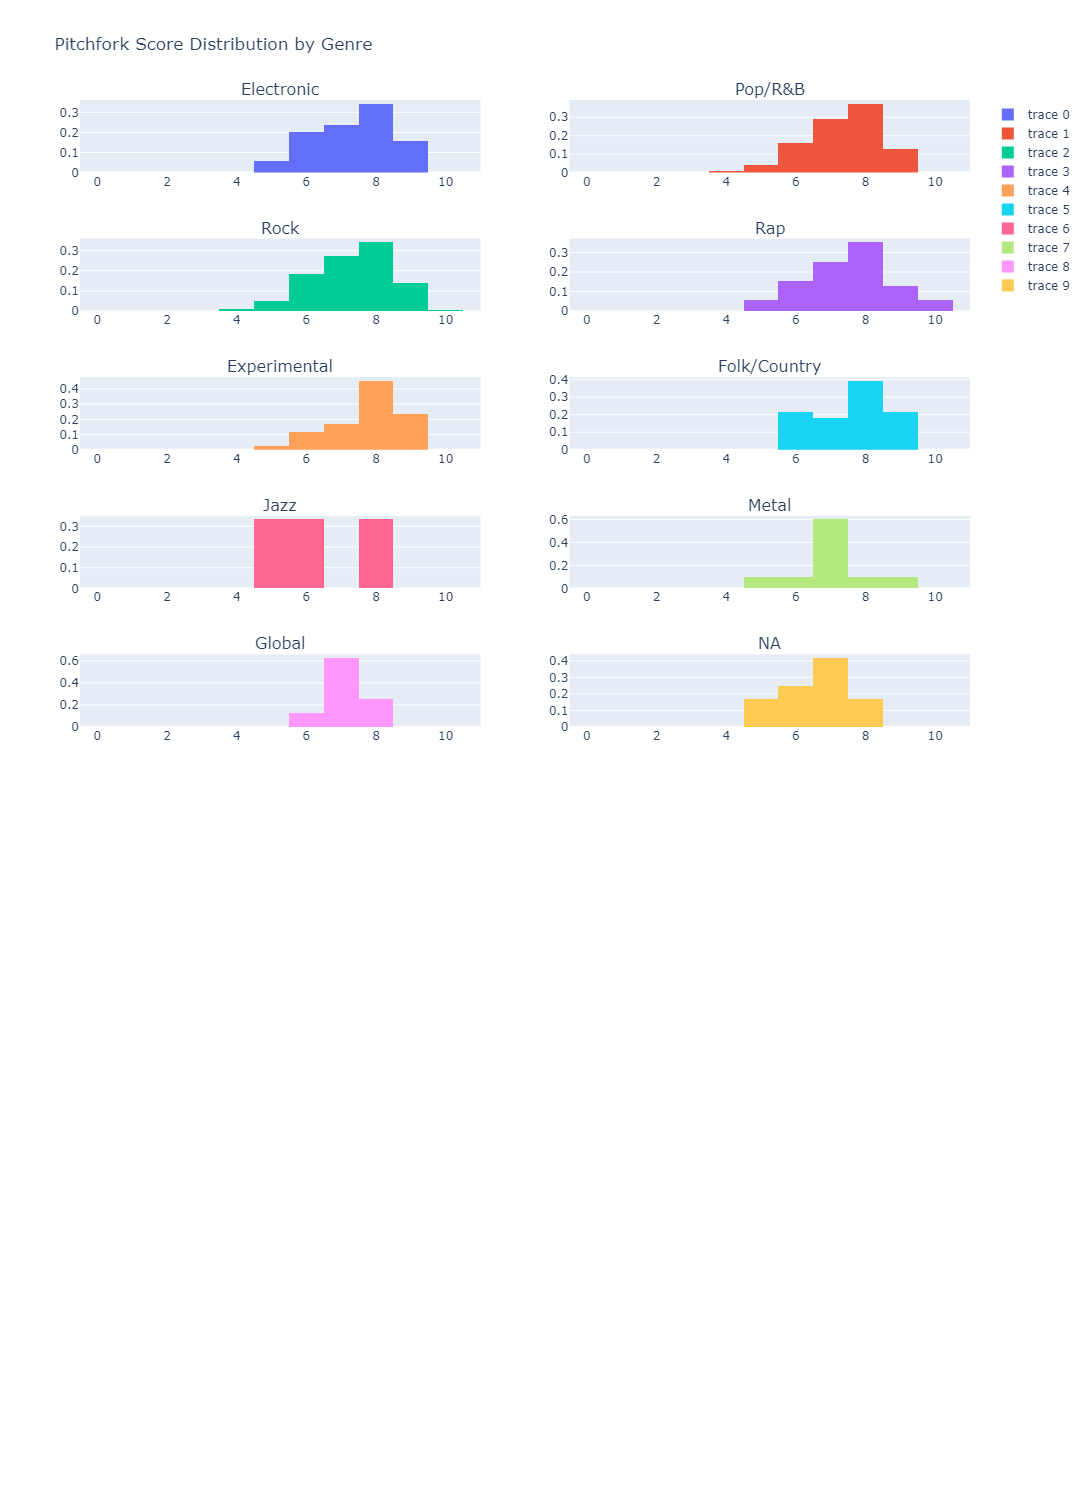

In [38]:
fig = make_subplots(rows=10, cols=2, subplot_titles=pf_genres)

for i in range(1, 7):
    for j in range(1, 3):
        
        index = 2 * (i - 1) + j - 1              
    
        if index >= len(pf_genres):
            break
    
        genre = pf_genres[index]
        
        fig.add_trace(go.Histogram(x=pf_df.loc[pf_df["Genres"] == genre, "Scores"],
                                   xbins={"start": -0.5,
                                          "end": 10.5,
                                          "size": 1},
                                  histnorm="probability density"), row=i, col=j)
        
fig.update_layout(title_text="Pitchfork Score Distribution by Genre", height=1500)
fig.update_xaxes(range=[-0.5, 11])
        
fig

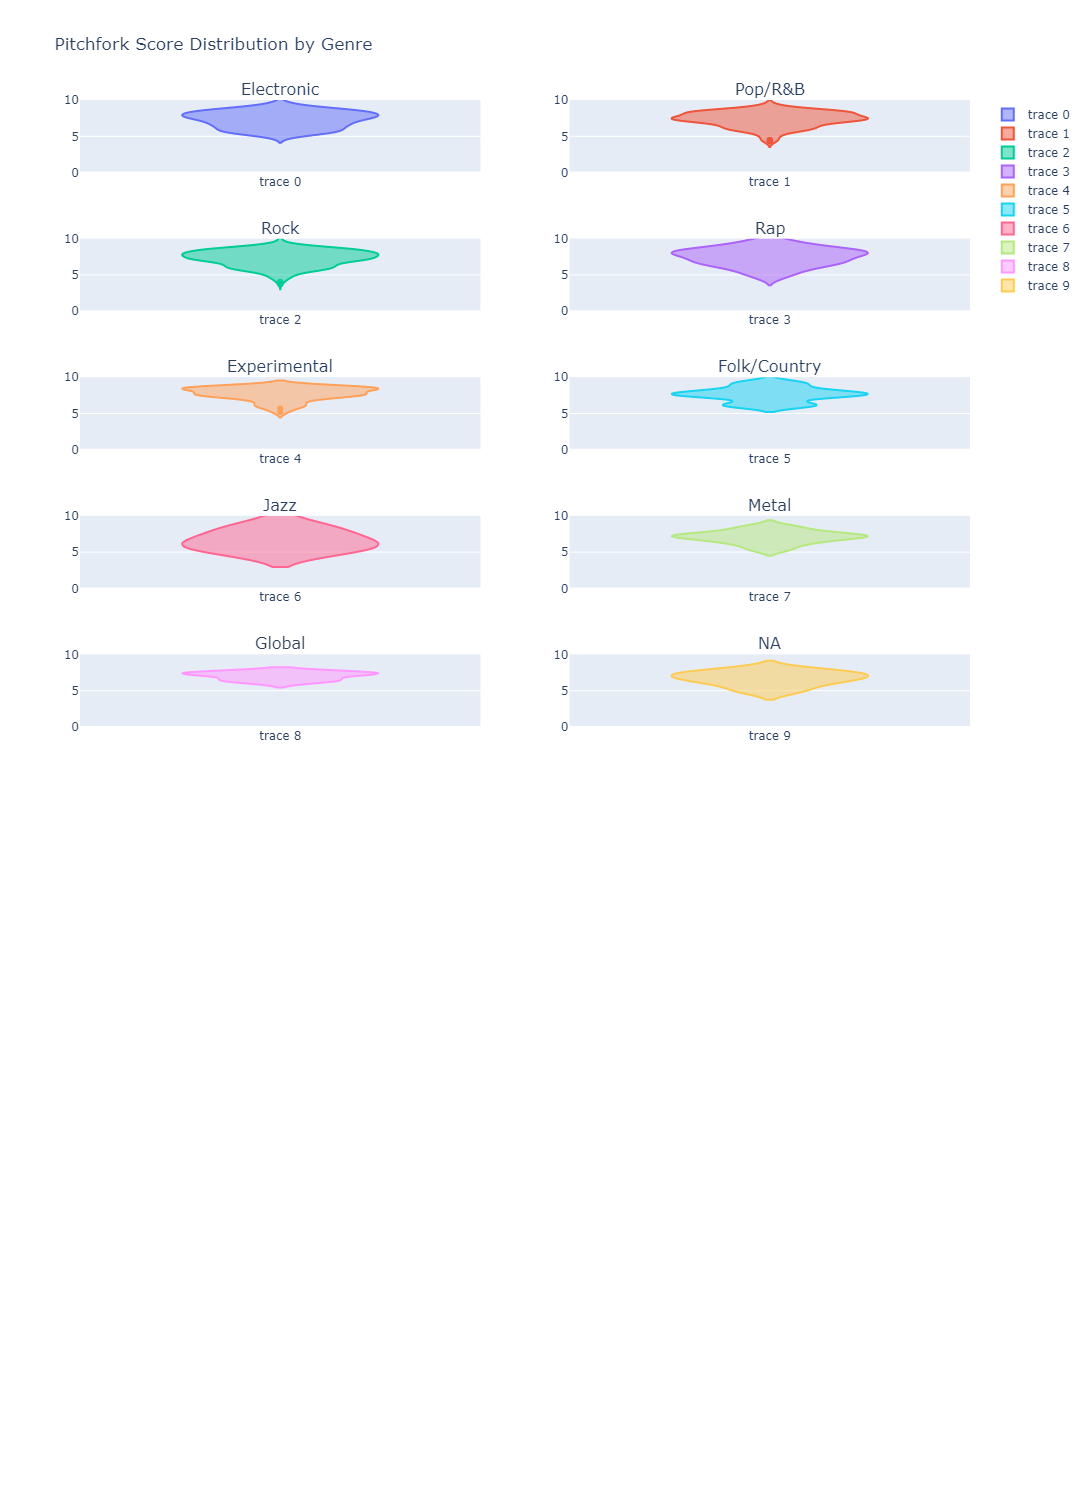

In [39]:
fig = make_subplots(rows=10, cols=2, subplot_titles=pf_genres)

for i in range(1, 7):
    for j in range(1, 3):
        
        index = 2 * (i - 1) + j - 1
    
        if index >= len(pf_genres):
            break
        
        genre = pf_genres[index]
        
        fig.add_trace(go.Violin(y=pf_df.loc[pf_df["Genres"] == genre, "Scores"]), row=i, col=j)
        
fig.update_layout(title_text="Pitchfork Score Distribution by Genre", height=1500)
fig.update_yaxes(range=[0, 10])
        
fig

In [40]:
genre_df = pd.merge(g_df.loc[:, ["Artist", "Album", "Genres"]].rename({"Genres": "Guardian Genres"}, axis=1),
                    pf_df.loc[:, ["Artist", "Album", "Genres"]].rename({"Genres": "Pitchfork Genres"}, axis=1),
                    how="inner", on=["Artist", "Album"]).drop_duplicates().reset_index(drop=True)

genre_cross = pd.crosstab(genre_df.loc[:, "Guardian Genres"], genre_df.loc[:, "Pitchfork Genres"], normalize="index")

(genre_cross * 100).style.background_gradient()

In [41]:
g_split = g_df.copy()
g_split.loc[g_split["Genres"] == "popandrock", "Genres"] = g_split.loc[
    g_split["Genres"] == "popandrock", "Genres"].apply(lambda x: ["Pop", "Rock"])
g_split = g_split.explode("Genres")

pf_split = pf_df.copy()
pf_split.loc[pf_split["Genres"] == "Pop/R&B", "Genres"] = pf_split.loc[
    pf_split["Genres"] == "Pop/R&B", "Genres"].apply(lambda x: ["Pop", "R&B"])
pf_split = pf_split.explode("Genres")

genre_df = pd.merge(g_split.loc[:, ["Artist", "Album", "Genres"]].rename({"Genres": "Guardian Genres"}, axis=1),
                    pf_split.loc[:, ["Artist", "Album", "Genres"]].rename({"Genres": "Pitchfork Genres"}, axis=1),
                    how="inner", on=["Artist", "Album"]).drop_duplicates().reset_index(drop=True)

genre_cross = pd.crosstab(genre_df.loc[:, "Guardian Genres"], genre_df.loc[:, "Pitchfork Genres"], normalize="index")
genre_cross

Pitchfork Genres    Electronic  Experimental  Folk/Country    Global  \
Guardian Genres                                                        
NA                    0.048780      0.109756      0.060976  0.012195   
Other                 0.151515      0.000000      0.000000  0.000000   
Pop                   0.107794      0.033167      0.016584  0.003317   
Rock                  0.107794      0.033167      0.016584  0.003317   
americana             0.000000      0.000000      0.166667  0.000000   
country               0.000000      0.000000      0.333333  0.000000   
dance-music           0.388060      0.000000      0.000000  0.029851   
electronicmusic       0.357143      0.023810      0.000000  0.023810   
experimental-music    0.222222      0.074074      0.037037  0.037037   
folk                  0.000000      0.086957      0.347826  0.000000   
hip-hop               0.086207      0.000000      0.000000  0.000000   
indie                 0.061611      0.047393      0.018957  0.000000   
jazz                  0.181818      0.181818      0.000000  0.000000   
metal                 0.000000      0.000000      0.000000  0.000000   
psychedelia           0.052632      0.105263      0.000000  0.000000   
punk                  0.027027      0.000000      0.000000  0.000000   
r-and-b               0.061538      0.000000      0.000000  0.000000   
rap                   0.051282      0.000000      0.000000  0.000000   
soul                  0.051282      0.000000      0.000000  0.000000   

Pitchfork Genres        Jazz     Metal        NA       Pop       R&B  \
Guardian Genres                                                        
NA                  0.000000  0.012195  0.000000  0.134146  0.134146   
Other               0.000000  0.000000  0.030303  0.272727  0.272727   
Pop                 0.001658  0.011609  0.009950  0.167496  0.167496   
Rock                0.001658  0.011609  0.009950  0.167496  0.167496   
americana           0.000000  0.000000  0.000000  0.000000  0.000000   
country             0.000000  0.000000  0.000000  0.000000  0.000000   
dance-music         0.014925  0.000000  0.000000  0.179104  0.179104   
electronicmusic     0.000000  0.000000  0.007937  0.198413  0.198413   
experimental-music  0.000000  0.000000  0.037037  0.074074  0.074074   
folk                0.000000  0.000000  0.000000  0.043478  0.043478   
hip-hop             0.000000  0.000000  0.017241  0.155172  0.155172   
indie               0.000000  0.004739  0.018957  0.066351  0.066351   
jazz                0.000000  0.000000  0.000000  0.181818  0.181818   
metal               0.000000  0.200000  0.200000  0.000000  0.000000   
psychedelia         0.000000  0.000000  0.000000  0.000000  0.000000   
punk                0.000000  0.027027  0.027027  0.000000  0.000000   
r-and-b             0.000000  0.000000  0.000000  0.446154  0.446154   
rap                 0.000000  0.000000  0.025641  0.179487  0.179487   
soul                0.051282  0.000000  0.000000  0.307692  0.307692   

Pitchfork Genres         Rap      Rock  
Guardian Genres                         
NA                  0.073171  0.414634  
Other               0.060606  0.212121  
Pop                 0.048093  0.432836  
Rock                0.048093  0.432836  
americana           0.000000  0.833333  
country             0.000000  0.666667  
dance-music         0.029851  0.179104  
electronicmusic     0.023810  0.166667  
experimental-music  0.074074  0.370370  
folk                0.000000  0.478261  
hip-hop             0.568966  0.017241  
indie               0.000000  0.715640  
jazz                0.000000  0.272727  
metal               0.000000  0.600000  
psychedelia         0.000000  0.842105  
punk                0.054054  0.864865  
r-and-b             0.000000  0.046154  
rap                 0.564103  0.000000  
soul                0.076923  0.205128

Let's try grouping together intuitively

In [42]:
mappings = {"dance-music": "Electronic",
            "electronicmusic": "Electronic",
            "folk": "Folk_Country",
            "country": "Folk_Country",
            "americana": "Folk_Country",
            "hip-hop": "Rap",
            "Other": "NA",
            "indie": "Rock",
            "punk": "Rock",
            "soul": "R&B",
            "psychedelia": "Rock",
            "experimental-music": "Experimental",
            "jazz": "Jazz",
            "metal": "Metal",
            "rap": "Rap",
            "r-and-b": "R&B"}

pf_mappings = {"Folk/Country": "Folk_Country",
               "Global": "NA",}

def map_g_genre(x, mappings):
    
    if x in mappings.keys():
        x = mappings[x]
        
    return x

genre_df.loc[:, "Guardian Genres"] = genre_df.loc[:, "Guardian Genres"].apply(lambda x: map_g_genre(x, mappings))
genre_df.loc[:, "Pitchfork Genres"] = genre_df.loc[:, "Pitchfork Genres"].apply(lambda x: map_g_genre(x, pf_mappings))

mapped_genre_cross = pd.crosstab(genre_df.loc[:, "Guardian Genres"], genre_df.loc[:, "Pitchfork Genres"], normalize="columns")
mapped_genre_cross.style.background_gradient().format("{0:.2%}")

In [43]:
genres = ["Electronic", "Experimental", "Folk_Country", "Jazz", "Metal", "NA", "Pop", "R&B", "Rap", "Rock"]
genre_set = genre_df.groupby(["Album", "Artist"]).agg(lambda x: set(x))

In [44]:
genre_set.loc[genre_set["Guardian Genres"].apply(lambda x: "Jazz" in x), :]

Guardian Genres  \
Album                    Artist                                                        
amok                     atoms for peace               {Rock, Jazz, Pop, Electronic}   
blank project            neneh cherry                  {Rock, Jazz, Pop, Electronic}   
cavalcade                black midi                  {Rock, Jazz, Experimental, Pop}   
everything was beautiful spiritualized                             {Rock, Jazz, Pop}   
flamagra                 flying lotus     {Jazz, Electronic, R&B, Experimental, Rap}   
grae                     moses sumney                         {Rock, Jazz, Pop, R&B}   
negro swan               blood orange                    {Jazz, R&B, Rock, Pop, Rap}   
you're dead!             flying lotus                        {Jazz, Rap, Electronic}   

                                              Pitchfork Genres  
Album                    Artist                                 
amok                     atoms for peace        {Experimental}  
blank project            neneh cherry               {Pop, R&B}  
cavalcade                black midi                     {Rock}  
everything was beautiful spiritualized    {Rock, Experimental}  
flamagra                 flying lotus             {Electronic}  
grae                     moses sumney                   {Rock}  
negro swan               blood orange               {Pop, R&B}  
you're dead!             flying lotus             {Electronic}

In [45]:
crosstab2 = {genre: {genre: 0 for genre in genres} for genre in genres}

for g, pf in zip(list(genre_set.loc[:, "Guardian Genres"]), list(genre_set.loc[:, "Pitchfork Genres"])):
    
    correct = g.intersection(pf)
    incorrect = g.symmetric_difference(pf)
    
    n_correct = len(correct)
    n_incorrect = len(incorrect)
    
    if n_correct >= 1:
        
        for genre in correct:
            crosstab2[genre][genre] += 1 / n_correct
    else:
        
        n_total = len(g) * len(pf)
        
        for i in range(len(g)):
            for j in range(len(pf)):

                crosstab2[list(g)[i]][list(pf)[j]] += 1 / n_total

crosstab2 = {genre: list(crosstab2[genre].values()) for genre in genres}

crosstab2_df = pd.DataFrame(crosstab2, index=genres)
crosstab2_df.div(crosstab2_df.sum(axis=0), axis=1).style.background_gradient().format("{0:.2%}")

In [46]:
d_sum = sum([crosstab2_df.iloc[i, i] for i in range(crosstab2_df.shape[0])])
d_sum / 641 * 100

80.03120124804992

In [47]:
crosstab3 = {genre: {genre: 0 for genre in genres} for genre in genres}

for g, pf in zip(list(genre_set.loc[:, "Guardian Genres"]), list(genre_set.loc[:, "Pitchfork Genres"])):
    
    correct = g.intersection(pf)
    incorrect = g.symmetric_difference(pf)
    
    n_incorrect = len(incorrect)
    n_correct = len(correct)
    
    if n_incorrect == 0:
        
        for genre in correct:
            
            crosstab3[genre][genre] += 1 / n_correct
    else:
        
        n_total = len(g) * len(pf)
        
        for i in range(len(g)):
            for j in range(len(pf)):

                crosstab3[list(g)[i]][list(pf)[j]] += 1 / n_total

crosstab3 = {genre: list(crosstab3[genre].values()) for genre in genres}

crosstab3_df = pd.DataFrame(crosstab3, index=genres)
crosstab3_df.div(crosstab3_df.sum(axis=0), axis=1).style.background_gradient().format("{0:.2%}")

In [48]:
def calculate_kappa(df):
    
    p_e = sum([df.loc[genre, :].sum() * df.loc[:, genre].sum()]) / (641 ** 2)
    p_0 = sum([df.iloc[i, i] for i in range(df.shape[0])]) / 641
    
    return (p_0 - p_e) / (1 - p_e)

print(f"Method 1 kappa: {calculate_kappa(crosstab2_df)}")
print(f"Method 2 kappa: {calculate_kappa(crosstab3_df)}")

Method 1 kappa: 0.724839038372
Method 2 kappa: 0.20540523123989346


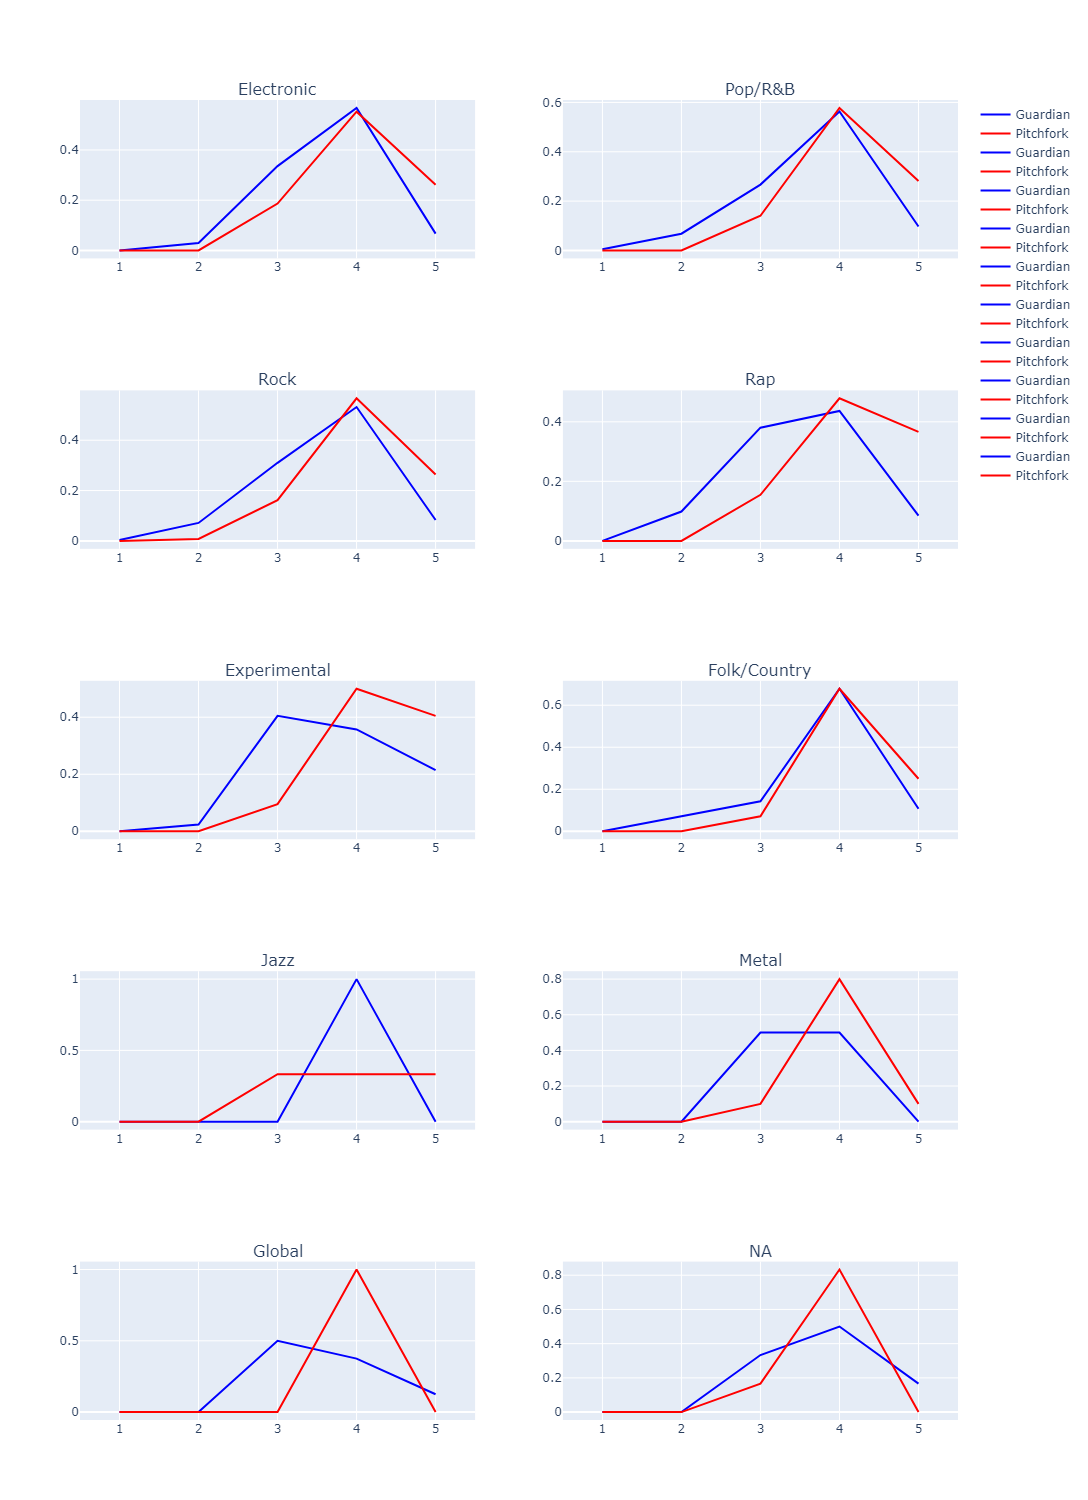

In [49]:
from math import ceil

fig = make_subplots(rows=5, cols=2, subplot_titles=pf_genres)
dist_g = g_df.copy()
dist_pf = pf_df.copy()

dist_g.loc[:, "Genres"] = dist_pf.loc[:, "Genres"].reset_index(drop=True)

dist_df = pd.concat([dist_g.loc[:, ["Artist", "Album", "Genres", "Scores", "Platform"]], 
                   dist_pf.loc[:, ["Artist", "Album", "Genres", "Scores", "Platform"]]]).reset_index(drop=True)

dist_df.loc[dist_df["Platform"] == "Pitchfork", "Scores"] = dist_df.loc[dist_df["Platform"] == "Pitchfork", "Scores"].apply(lambda x: ceil(x / 2))

dist_data = {}

for genre in pf_genres:
    
    g_genre_data = dist_df.loc[(dist_df["Platform"] == "Guardian") & (dist_df["Genres"] == genre), "Scores"].value_counts(
        normalize=True).reindex([x for x in range(1, 6)], fill_value=0)
    pf_genre_data = dist_df.loc[(dist_df["Platform"] == "Pitchfork") & (dist_df["Genres"] == genre), "Scores"].value_counts(
        normalize=True).reindex([x for x in range(1, 6)], fill_value=0)
    
    dist_data[genre] = [pd.DataFrame({"Platform": ["Guardian" for x in range(g_genre_data.shape[0])],
                                                "Scores": g_genre_data.index,
                                                "Proportion": g_genre_data.values}).sort_values("Scores"),
                                  pd.DataFrame({"Platform": ["Pitchfork" for x in range(pf_genre_data.shape[0])],
                                                "Scores": pf_genre_data.index,
                                                "Proportion": pf_genre_data.values}).sort_values("Scores")]

for i in range(1, 6):
    for j in range(1, 3):

        index = 2 * (i - 1) + j - 1
        
        if index >= len(pf_genres):
            break
        
        genre = pf_genres[index]        
        fig.add_trace(go.Scatter(x=dist_data[genre][0].loc[:, "Scores"], y=dist_data[genre][0].loc[:, "Proportion"], mode="lines",
                                line=dict(color="blue"), name="Guardian"), row=i, col=j)
        fig.add_trace(go.Scatter(x=dist_data[genre][1].loc[:, "Scores"], y=dist_data[genre][1].loc[:, "Proportion"], mode="lines",
                                line=dict(color="red"), name="Pitchfork"), row=i, col=j)

fig.update_layout(height=1500)
fig.update_xaxes(range=[0.5, 5.5])

In [50]:
g_df_ave = g_df.groupby(by=["Album", "Artist"])["Scores"].mean().reset_index()
g_df_ave = pd.merge(g_df_ave, g_df_genre.loc[:, ["Artist", "Album", "Genres"]],
                    on=["Artist", "Album"], how="inner")

dfs_ave = {k: df.drop_duplicates(subset=["Artist", "Album"]) for k, df in dfs.items()}
dfs_ave["Guardian"] = g_df_ave

[df.shape[0] for df in dfs_ave.values()]

[641, 641, 641, 641]

In [51]:
g_df_ave

Album        Artist  Scores  \
0              1989  taylor swift     4.0   
1                 2   mac demarco     3.0   
2                25         adele     3.0   
3              2:54          2:54     2.0   
4                 4       beyonce     3.5   
..              ...           ...     ...   
636          yeezus    kanye west     4.0   
637    you're dead!  flying lotus     5.0   
638  you're nothing        iceage     3.0   
639  you're the man   marvin gaye     3.0   
640            yuck          yuck     4.0   

                                      Genres  
0                           [NA, popandrock]  
1                                    [indie]  
2                               [popandrock]  
3                                    [indie]  
4                      [r-and-b, popandrock]  
..                                       ...  
636  [hip-hop, electronicmusic, dance-music]  
637         [jazz, electronicmusic, hip-hop]  
638                        [NA, punk, metal]  
639                   [soul, r-and-b, Other]  
640                                  [indie]  

[641 rows x 4 columns]

In [52]:
pf_df_ave = dfs_ave["Pitchfork"]

genre_df_ave = pd.merge(g_df_ave.explode("Genres").loc[:, ["Artist", "Album", "Genres"]], 
                        pf_df_ave.explode("Genres").loc[:, ["Artist", "Album", "Genres"]],
                    how="inner", on=["Artist", "Album"]).reset_index(drop=True)

genre_cross = pd.crosstab(genre_df.loc[:, "Guardian Genres"], genre_df.loc[:, "Pitchfork Genres"])
genre_cross

Pitchfork Genres  Electronic  Experimental  Folk_Country  Jazz  Metal  NA  \
Guardian Genres                                                             
Electronic                71             3             0     1      0   6   
Experimental               6             2             1     0      0   2   
Folk_Country               0             2            13     0      0   0   
Jazz                       2             2             0     0      0   0   
Metal                      0             0             0     0      2   2   
NA                         9             9             5     0      1   2   
Pop                       65            20            10     1      7   8   
R&B                        6             0             0     2      0   0   
Rap                        7             0             0     0      0   2   
Rock                      80            32            14     1      9  13   

Pitchfork Genres  Pop  R&B  Rap  Rock  
Guardian Genres                        
Electronic         37   37    5    33  
Experimental        2    2    2    10  
Folk_Country        1    1    0    27  
Jazz                2    2    0     3  
Metal               0    0    0     6  
NA                 20   20    8    41  
Pop               101  101   29   261  
R&B                41   41    3    11  
Rap                16   16   55     1  
Rock              115  115   31   460

In [53]:
genre_summary_df = g_df_ave.rename({"Scores": "Guardian Score"}, axis=1)

for platform in ["Pitchfork", "Spectrum", "NME"]:
    
    genre_summary_df = pd.merge(genre_summary_df,
                                dfs_ave[platform].loc[:, ["Album", "Artist", "Scores"]].rename(
                                    {"Scores": f"{platform} Score"}, axis=1),
                                on=["Artist", "Album"], how="inner")
    
genre_summary_df = genre_summary_df.melt(id_vars=["Artist", "Album", "Genres"], 
                                         value_vars=["Pitchfork Score", "Spectrum Score", "NME Score", "Guardian Score"],
                                         value_name="Score",
                                         var_name="Platform")
genre_summary_df = genre_summary_df.explode("Genres").drop(columns=["Artist", "Album"])
genre_summary_df = genre_summary_df.groupby(["Genres", "Platform"]).agg(
    [lambda x: x.loc[x == i].count() for i in range(1, 6)])
genre_summary_df

Score                                            
                       <lambda_0> <lambda_1> <lambda_2> <lambda_3> <lambda_4>
Genres Platform                                                              
NA     Guardian Score           3          3          3          3          3
       NME Score               11         11         11         11         11
       Pitchfork Score          0          0          0          0          0
       Spectrum Score           0          0          0          0          0
Other  Guardian Score           0          0          0          0          0
...                           ...        ...        ...        ...        ...
rap    Spectrum Score           0          0          0          0          0
soul   Guardian Score           2          2          2          2          2
       NME Score                3          3          3          3          3
       Pitchfork Score          0          0          0          0          0
       Spectrum Score           0          0          0          0          0

[72 rows x 5 columns]

In [54]:
x = pd.Series([1, 2, 3, 4, 1])
x.loc[x == 5].count()

0

There is no missing data for genre and score so we can move on

## EDA on score data

In [55]:
# First removing the null data for spectrum

score_dfs = {platform: df.copy().sort_values("Scores") for platform, df in dfs_ave.items()}
score_dfs["Spectrum"] = score_dfs["Spectrum"].loc[score_dfs["Spectrum"]["Scores"] != - 1]

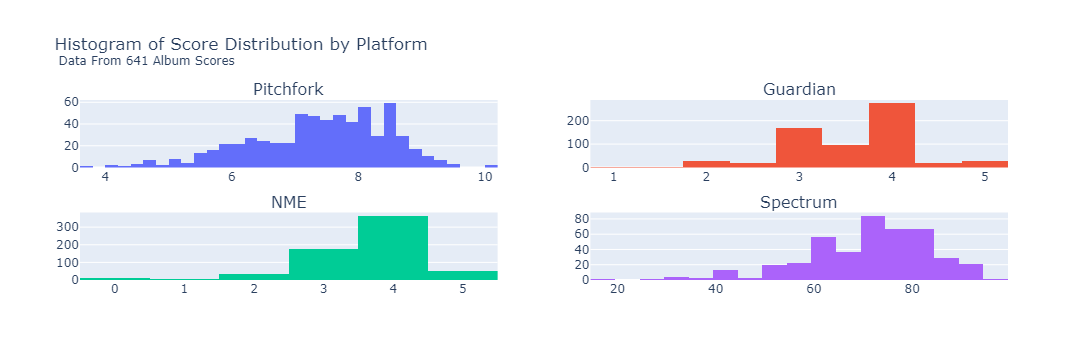

In [56]:
fig = make_subplots(rows=2, cols=2, subplot_titles=list(score_dfs.keys()))
i = 0

for platform, df in score_dfs.items():
    
    i += 1
    
    if platform == "Guardian":
        fig.add_trace(go.Histogram(x=df.loc[:, "Scores"], nbinsx=9), row=(i - 1) // 2 + 1, col=(i + 1) % 2 + 1)
    
    else:
        fig.add_trace(go.Histogram(x=df.loc[:, "Scores"]), row=(i - 1) // 2 + 1, col=(i + 1) % 2 + 1)
    
fig.update_layout(showlegend=False, title="Histogram of Score Distribution by Platform <br><sup> Data From 641 Album Scores")

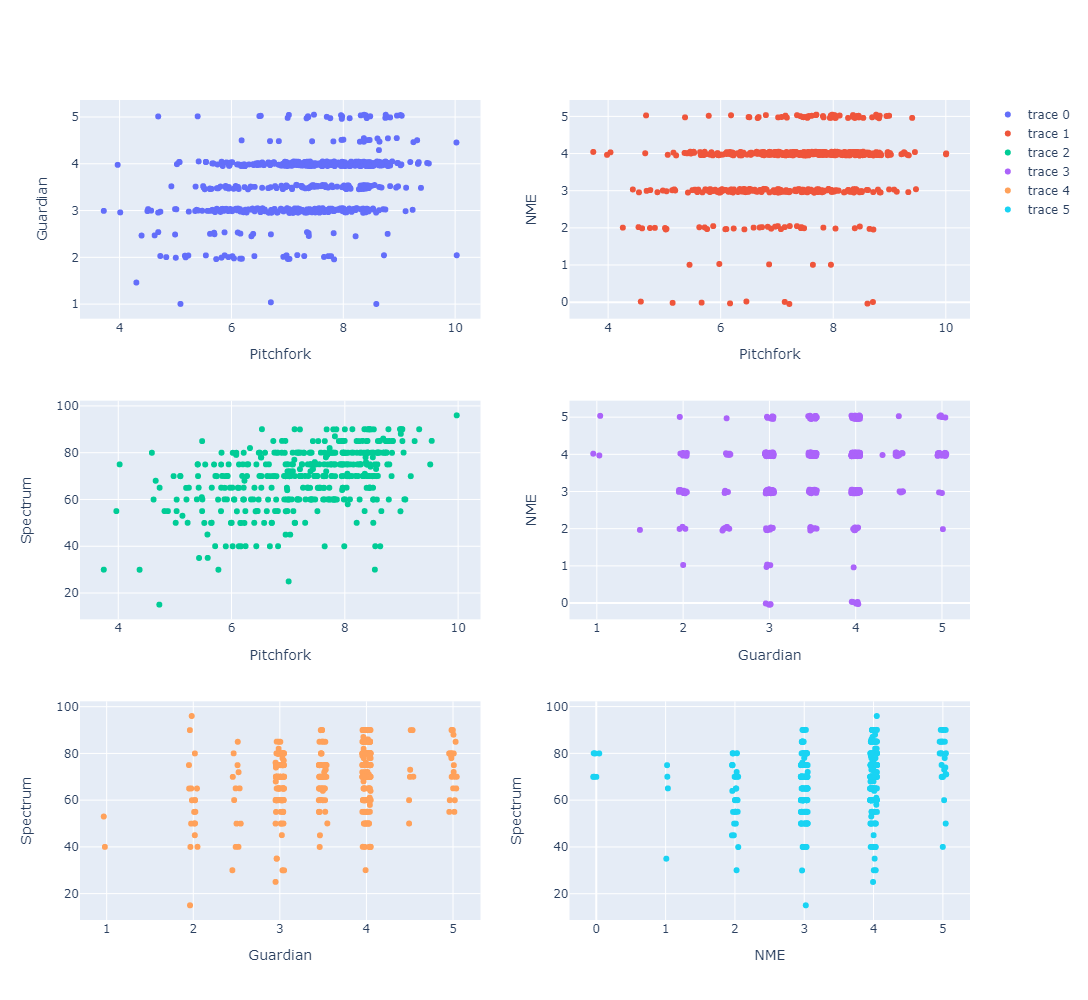

In [57]:
def jitter(x, intensity):
    
    return x + np.random.uniform(low=-intensity, high=intensity)

fig = make_subplots(rows=3, cols=2)

plot = 0

for i in range(4):
    for j in range(i + 1, 4):
        
        plot += 1
        
        k1, df1 = list(score_dfs.keys())[i], list(score_dfs.values())[i]
        k2, df2 = list(score_dfs.keys())[j], list(score_dfs.values())[j]
        df1 = df1.rename(columns={"Scores": "Scores1"})
        df2 = df2.rename(columns={"Scores": "Scores2"})
        
        joined_scores = pd.merge(df1, df2, on=["Artist", "Album"])
        
        row = (plot - 1) // 2 + 1
        col = (plot - 1) % 2 + 1
                
        fig.add_trace(go.Scatter(x=joined_scores.loc[:, "Scores1"].apply(jitter, intensity=0.05), y=joined_scores.loc[:, "Scores2"].apply(jitter, intensity=0.05), mode="markers"),
                      row=row, col=col)
        fig.update_xaxes(title_text=k1, row=row, col=col)
        fig.update_yaxes(title_text=k2, row=row, col=col)
        
    fig.update_layout(height=1000)
        
fig

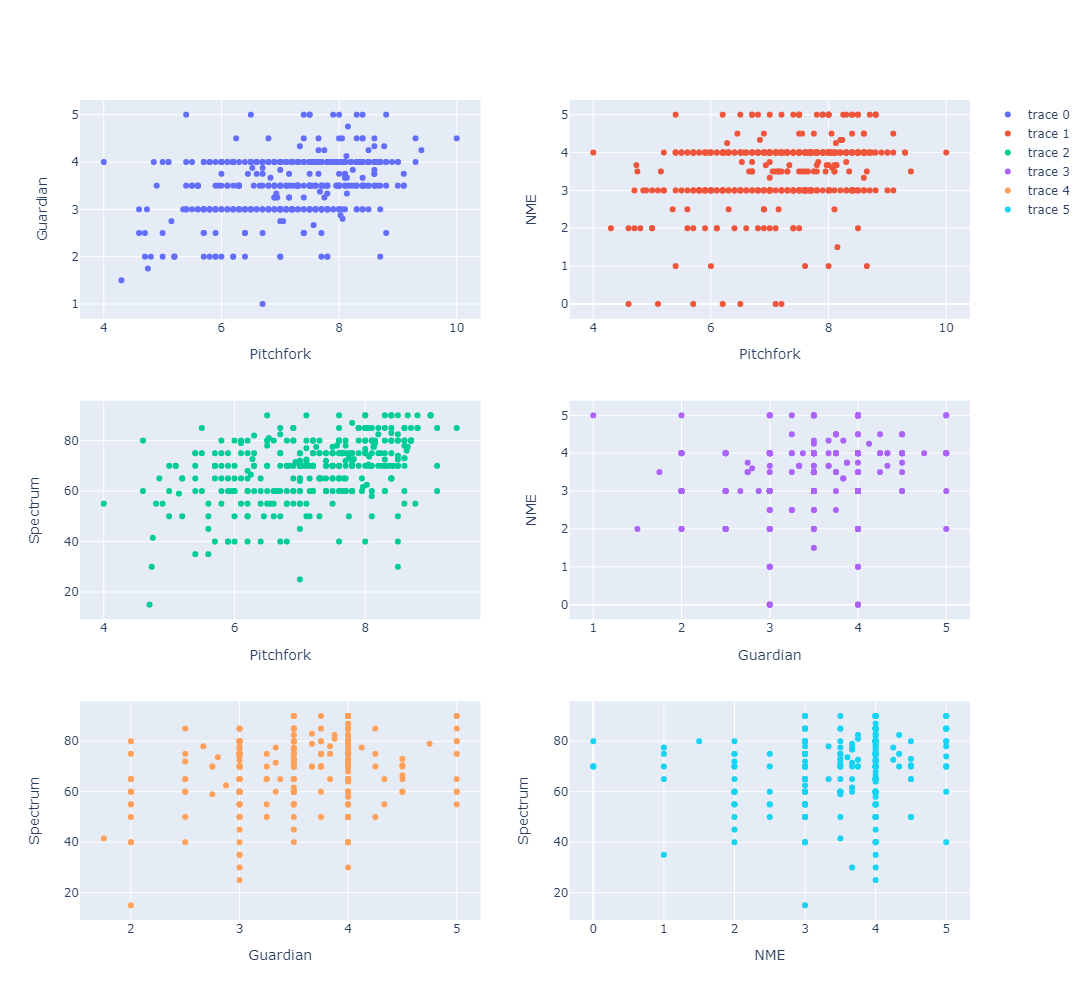

In [58]:
artist_ave = {platform: df.groupby("Artist")["Scores"].mean().reset_index() for platform, df in score_dfs.items()}

fig = make_subplots(rows=3, cols=2)

plot = 0

for i in range(4):
    for j in range(i + 1, 4):
        
        plot += 1
        
        k1, df1 = list(artist_ave.keys())[i], list(artist_ave.values())[i]
        k2, df2 = list(artist_ave.keys())[j], list(artist_ave.values())[j]
        df1 = df1.rename(columns={"Scores": "Scores1"})
        df2 = df2.rename(columns={"Scores": "Scores2"})
        
        joined_scores = pd.merge(df1, df2, on=["Artist"])
        
        row = (plot - 1) // 2 + 1
        col = (plot - 1) % 2 + 1
                
        fig.add_trace(go.Scatter(x=joined_scores.loc[:, "Scores1"], y=joined_scores.loc[:, "Scores2"], mode="markers"),
                      row=row, col=col)
        fig.update_xaxes(title_text=k1, row=row, col=col)
        fig.update_yaxes(title_text=k2, row=row, col=col)
        
    fig.update_layout(height=1000)
        
fig

In [59]:
std_scores = {}

all_scores = score_dfs["Pitchfork"].loc[:, [col not in ["Url", "Text", "Platform"] for col in score_dfs["Pitchfork"].columns]].rename({"Scores": "Pitchfork Scores"}, axis=1)

for platform in ["Guardian", "NME"]:
    
    next_platform = score_dfs[platform].loc[:, [col not in ["Url", "Text", "Platform", "Genres"] for col in score_dfs[platform].columns]].rename({"Scores": f"{platform} Scores"}, axis=1)
    all_scores = pd.merge(all_scores, next_platform,
                          on=["Artist", "Album"])

all_scores.loc[:, "Guardian Scores"] = all_scores.loc[:, "Guardian Scores"].multiply(2)
all_scores.loc[:, "NME Scores"] = all_scores.loc[:, "NME Scores"].astype(float).multiply(2)
all_scores = all_scores.sort_values(by="Album").reset_index(drop=True)

averages = all_scores.loc[:, ["Pitchfork Scores", "Guardian Scores", "NME Scores"]].mean(axis=1)

sp_filled = dfs_ave["Spectrum"].copy().sort_values(by="Album").reset_index(drop=True)
sp_no_data = sp_filled["Scores"] == -1
sp_filled.loc[~sp_no_data, "Scores"] = sp_filled.loc[~sp_no_data, "Scores"].div(10)
sp_filled.loc[sp_no_data, "Scores"] = averages.loc[sp_no_data]
sp_filled = sp_filled.rename({"Scores": "Spectrum Scores"}, axis=1).drop(["Platform", "Url"], axis=1)

all_scores = pd.merge(all_scores, sp_filled, on=["Artist", "Album"])

all_scores["Average Score"] = all_scores.loc[:, ["Pitchfork Scores", "Guardian Scores", "NME Scores", "Spectrum Scores"]].mean(axis=1)

all_scores.head()

Artist Album  Pitchfork Scores     Genres  Guardian Scores  \
0  taylor swift  1989               7.7  [Pop/R&B]              8.0   
1   mac demarco     2               8.2     [Rock]              6.0   
2         adele    25               7.3  [Pop/R&B]              6.0   
3          2:54  2:54               6.0  [Pop/R&B]              4.0   
4       beyonce     4               8.0  [Pop/R&B]              7.0   

   NME Scores                                               Text  \
0         6.0  1989 is Taylor Swift’s pop album. That is the ...   
1         8.0  On his early Makeout Videotape recordings, or ...   
2         6.0  \nNot quite a pop star, not exactly a diva, Ad...   
3         8.0  Few critics seriously enjoy giving negative re...   
4         4.0  \n\nBeyoncé \n4 \nRating: 3.2/5.0 \nLabel: Col...   

   Spectrum Scores  Average Score  
0         6.000000       6.925000  
1         7.000000       7.300000  
2         6.433333       6.433333  
3         4.000000       5.500000  
4         6.400000       6.350000

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_error(scoring, df):
    sp_error = scoring(df.loc[~sp_no_data, "Spectrum Scores"], df.loc[~sp_no_data, "Average Score"])
    errors = {platform: scoring(df.loc[:, f"{platform} Scores"], df.loc[:, "Average Score"]) for platform in platforms}
    errors["Spectrum"] = sp_error

    return pd.DataFrame(errors, index=["Platform"]).T

get_error(mean_squared_error, all_scores)

Platform
Pitchfork  0.658918
Guardian   1.032126
NME        1.514968
Spectrum   0.937820

In [61]:
get_error(mean_absolute_error, all_scores)

Platform
Pitchfork  0.627552
Guardian   0.772066
NME        0.891740
Spectrum   0.739428

In [62]:
sp_errors = all_scores.loc[~sp_no_data, :].apply(lambda x: (x["Spectrum Scores"] - x["Average Score"]) ** 2, axis=1)
errors = {platform: all_scores.apply(lambda x: (x[f"{platform} Scores"] - x["Average Score"]) ** 2, axis=1) for platform in platforms}
errors["Spectrum"] = sp_errors

errors_df = pd.DataFrame(errors)

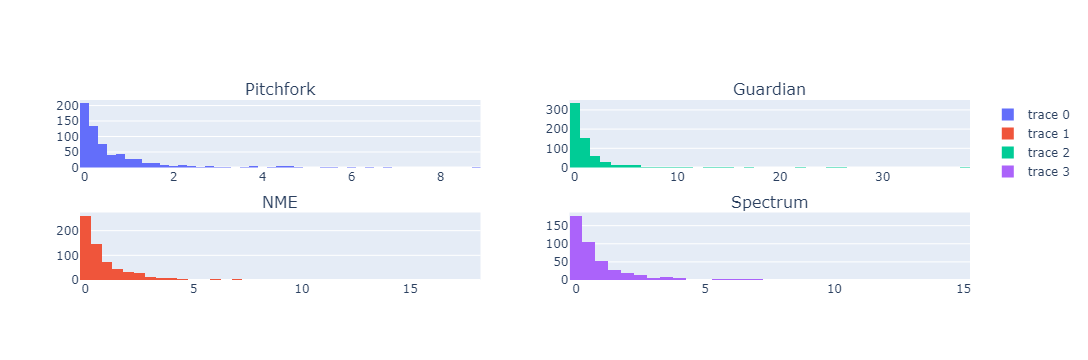

In [63]:
fig = make_subplots(rows=2, cols=2, subplot_titles=list(platforms))

i = 0

for platform in platforms:

    i += 1
    fig.add_trace(go.Histogram(x=errors_df.loc[:, platform]), row=(i - 1) % 2 + 1, col=(i - 1) // 2 + 1)
    
fig

In [64]:
errors_df = pd.merge(errors_df, all_scores, left_index=True, right_index=True)
errors_df

Pitchfork  Guardian       NME  Spectrum        Artist           Album  \
0     0.600625  1.155625  0.855625  0.855625  taylor swift            1989   
1     0.810000  1.690000  0.490000  0.090000   mac demarco               2   
2     0.751111  0.187778  0.187778       NaN         adele              25   
3     0.250000  2.250000  6.250000  2.250000          2:54            2:54   
4     2.722500  0.422500  5.522500  0.002500       beyonce               4   
..         ...       ...       ...       ...           ...             ...   
636   1.562500  0.062500  0.062500  0.562500    kanye west          yeezus   
637   0.160000  1.690000  0.490000  0.040000  flying lotus    you're dead!   
638   2.102500  1.322500  0.722500  1.322500        iceage  you're nothing   
639   0.017778  3.737778  4.271111       NaN   marvin gaye  you're the man   
640   0.390625  0.275625  0.275625  2.805625          yuck            yuck   

     Pitchfork Scores        Genres  Guardian Scores  NME Scores  \
0                 7.7     [Pop/R&B]              8.0         6.0   
1                 8.2        [Rock]              6.0         8.0   
2                 7.3     [Pop/R&B]              6.0         6.0   
3                 6.0     [Pop/R&B]              4.0         8.0   
4                 8.0     [Pop/R&B]              7.0         4.0   
..                ...           ...              ...         ...   
636               9.5         [Rap]              8.0         8.0   
637               8.3  [Electronic]             10.0         8.0   
638               8.6        [Rock]              6.0         8.0   
639               7.8     [Pop/R&B]              6.0        10.0   
640               8.1        [Rock]              8.0         8.0   

                                                  Text  Spectrum Scores  \
0    1989 is Taylor Swift’s pop album. That is the ...         6.000000   
1    On his early Makeout Videotape recordings, or ...         7.000000   
2    \nNot quite a pop star, not exactly a diva, Ad...         6.433333   
3    Few critics seriously enjoy giving negative re...         4.000000   
4    \n\nBeyoncé \n4 \nRating: 3.2/5.0 \nLabel: Col...         6.400000   
..                                                 ...              ...   
636  When Kanye West bombarded the “Saturday Night ...         7.500000   
637  There’s no point in saying that Steven Ellison...         8.500000   
638  The scene is littered with pop-punk bands tryi...         6.000000   
639  \nThe record being released as You’re the Man ...         7.933333   
640  \n\nYuck\nYuck\nRating: 2.9/5.0\nLabel: Fat Po...         5.800000   

     Average Score  
0         6.925000  
1         7.300000  
2         6.433333  
3         5.500000  
4         6.350000  
..             ...  
636       8.250000  
637       8.700000  
638       7.150000  
639       7.933333  
640       7.475000  

[641 rows x 13 columns]

In [65]:
errors_df.explode("Genres").loc[:, ["Pitchfork", "Spectrum", "Guardian", "NME", "Genres"]].groupby(["Genres"]).mean()

Pitchfork  Spectrum  Guardian       NME
Genres                                               
Electronic     0.755691  0.890037  1.179698  1.984380
Experimental   1.137704  1.238665  1.418795  1.267071
Folk/Country   0.422198  0.869602  0.494365  0.978531
Global         0.566028  0.307083  0.812028  0.555361
Jazz           1.708542  0.910208  2.751875  1.185208
Metal          0.941343  1.206458  1.747083  0.998935
NA             0.077917  1.284583  0.765139  0.920694
Pop/R&B        0.598261  0.775511  0.769120  1.515332
Rap            0.903328  0.990565  1.709700  1.319831
Rock           0.632487  0.978869  0.998565  1.483175

In [66]:
all_star_scores = all_scores.copy()

for platform in platforms:
    
    all_star_scores.loc[:, f"{platform} Scores"] = all_star_scores.loc[:, f"{platform} Scores"].div(2).apply(ceil)
    
all_star_scores.loc[:, "Average Score"] = all_star_scores.loc[:, ["Pitchfork Scores", "Guardian Scores", "NME Scores", "Spectrum Scores"]].mean(axis=1)

In [67]:
all_star_scores

Artist           Album  Pitchfork Scores        Genres  \
0    taylor swift            1989                 4     [Pop/R&B]   
1     mac demarco               2                 5        [Rock]   
2           adele              25                 4     [Pop/R&B]   
3            2:54            2:54                 3     [Pop/R&B]   
4         beyonce               4                 4     [Pop/R&B]   
..            ...             ...               ...           ...   
636    kanye west          yeezus                 5         [Rap]   
637  flying lotus    you're dead!                 5  [Electronic]   
638        iceage  you're nothing                 5        [Rock]   
639   marvin gaye  you're the man                 4     [Pop/R&B]   
640          yuck            yuck                 5        [Rock]   

     Guardian Scores  NME Scores  \
0                  4           3   
1                  3           4   
2                  3           3   
3                  2           4   
4                  4           2   
..               ...         ...   
636                4           4   
637                5           4   
638                3           4   
639                3           5   
640                4           4   

                                                  Text  Spectrum Scores  \
0    1989 is Taylor Swift’s pop album. That is the ...                3   
1    On his early Makeout Videotape recordings, or ...                4   
2    \nNot quite a pop star, not exactly a diva, Ad...                4   
3    Few critics seriously enjoy giving negative re...                2   
4    \n\nBeyoncé \n4 \nRating: 3.2/5.0 \nLabel: Col...                4   
..                                                 ...              ...   
636  When Kanye West bombarded the “Saturday Night ...                4   
637  There’s no point in saying that Steven Ellison...                5   
638  The scene is littered with pop-punk bands tryi...                3   
639  \nThe record being released as You’re the Man ...                4   
640  \n\nYuck\nYuck\nRating: 2.9/5.0\nLabel: Fat Po...                3   

     Average Score  
0             3.50  
1             4.00  
2             3.50  
3             2.75  
4             3.50  
..             ...  
636           4.25  
637           4.75  
638           3.75  
639           4.00  
640           4.00  

[641 rows x 9 columns]

In [68]:
get_error(mean_squared_error, all_star_scores)

Platform
Pitchfork  0.313670
Guardian   0.303530
NME        0.447055
Spectrum   0.290304

In [69]:
get_error(mean_absolute_error, all_star_scores)

Platform
Pitchfork  0.429407
Guardian   0.415367
NME        0.469189
Spectrum   0.411215

In [70]:
sp_star_errors = all_star_scores.loc[~sp_no_data, :].apply(lambda x: (x["Spectrum Scores"] - x["Average Score"]) ** 2, axis=1)
star_errors = {platform: all_star_scores.apply(lambda x: (x[f"{platform} Scores"] - x["Average Score"]) ** 2, axis=1) for platform in platforms}
star_errors["Spectrum"] = sp_star_errors

star_errors_df = pd.DataFrame(star_errors)

In [71]:
star_errors_df = pd.merge(star_errors_df, all_star_scores, left_index=True, right_index=True)

In [72]:
star_errors_df.explode("Genres").loc[:, ["Pitchfork", "Spectrum", "Guardian", "NME", "Genres"]].groupby(["Genres"]).mean().style.highlight_max(axis=1, color="pink")

In [73]:
all_star_scores

Artist           Album  Pitchfork Scores        Genres  \
0    taylor swift            1989                 4     [Pop/R&B]   
1     mac demarco               2                 5        [Rock]   
2           adele              25                 4     [Pop/R&B]   
3            2:54            2:54                 3     [Pop/R&B]   
4         beyonce               4                 4     [Pop/R&B]   
..            ...             ...               ...           ...   
636    kanye west          yeezus                 5         [Rap]   
637  flying lotus    you're dead!                 5  [Electronic]   
638        iceage  you're nothing                 5        [Rock]   
639   marvin gaye  you're the man                 4     [Pop/R&B]   
640          yuck            yuck                 5        [Rock]   

     Guardian Scores  NME Scores  \
0                  4           3   
1                  3           4   
2                  3           3   
3                  2           4   
4                  4           2   
..               ...         ...   
636                4           4   
637                5           4   
638                3           4   
639                3           5   
640                4           4   

                                                  Text  Spectrum Scores  \
0    1989 is Taylor Swift’s pop album. That is the ...                3   
1    On his early Makeout Videotape recordings, or ...                4   
2    \nNot quite a pop star, not exactly a diva, Ad...                4   
3    Few critics seriously enjoy giving negative re...                2   
4    \n\nBeyoncé \n4 \nRating: 3.2/5.0 \nLabel: Col...                4   
..                                                 ...              ...   
636  When Kanye West bombarded the “Saturday Night ...                4   
637  There’s no point in saying that Steven Ellison...                5   
638  The scene is littered with pop-punk bands tryi...                3   
639  \nThe record being released as You’re the Man ...                4   
640  \n\nYuck\nYuck\nRating: 2.9/5.0\nLabel: Fat Po...                3   

     Average Score  
0             3.50  
1             4.00  
2             3.50  
3             2.75  
4             3.50  
..             ...  
636           4.25  
637           4.75  
638           3.75  
639           4.00  
640           4.00  

[641 rows x 9 columns]

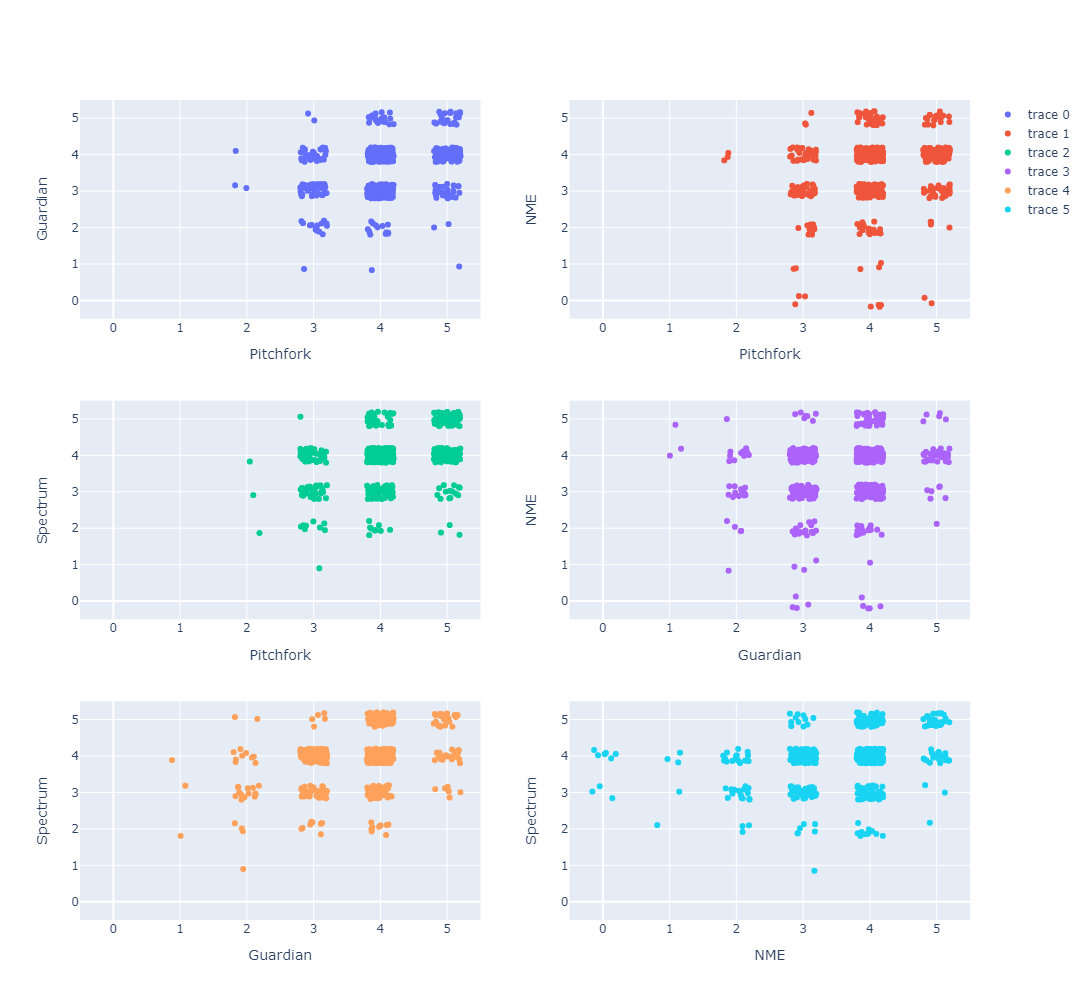

In [74]:
fig = make_subplots(rows=3, cols=2)
import random

plot = 0

for i in range(4):
    for j in range(i + 1, 4):
        
        plot += 1
        
        k1 = platforms[i]
        k2 = platforms[j]
        
        row = (plot - 1) // 2 + 1
        col = (plot - 1) % 2 + 1
                
        fig.add_trace(go.Scatter(x=all_star_scores.loc[:, f"{k1} Scores"].apply(jitter, intensity=0.2), 
                                 y=all_star_scores.loc[:, f"{k2} Scores"].apply(jitter, intensity=0.2), 
                                 mode="markers"),
                      row=row, col=col)
        fig.update_xaxes(title_text=k1, row=row, col=col, range=[-0.5, 5.5])
        fig.update_yaxes(title_text=k2, row=row, col=col, range=[-0.5, 5.5])
        
    fig.update_layout(height=1000)
        
fig

In [75]:
all_star_scores.loc[:, [f"{platform} Scores" for platform in platforms]].corr()

Pitchfork Scores  Guardian Scores  NME Scores  \
Pitchfork Scores          1.000000         0.314115    0.215333   
Guardian Scores           0.314115         1.000000    0.190603   
NME Scores                0.215333         0.190603    1.000000   
Spectrum Scores           0.408901         0.341795    0.311333   

                  Spectrum Scores  
Pitchfork Scores         0.408901  
Guardian Scores          0.341795  
NME Scores               0.311333  
Spectrum Scores          1.000000

In [76]:
all_scores.head(30).loc[7:20, all_scores.columns != "Text"]

Artist                                      Album  \
7             wutang clan                          a better tomorrow   
8                the 1975  a brief inquiry into online relationships   
9               sheer mag                             a distant call   
10  everything everything                              a fever dream   
11          the districts                     a flourish and a spoil   
12           fontaines dc                             a hero's death   
13                 m ward                      a wasteland companion   
14             the weeknd                                after hours   
15           broken bells                            after the disco   
16            merchandise                              after the end   
17             goodie mob                    age against the machine   
18            angel olsen                                all mirrors   
19         arctic monkeys                                         am   
20             dan deacon                                    america   

    Pitchfork Scores              Genres  Guardian Scores  NME Scores  \
7                5.9               [Rap]              6.0         6.0   
8                8.5              [Rock]              8.0        10.0   
9                7.8              [Rock]              8.0         8.0   
10               7.1              [Rock]              8.0         8.0   
11               5.6              [Rock]              6.0         8.0   
12               8.1              [Rock]             10.0         8.0   
13               6.3              [Rock]              7.0         6.0   
14               7.9           [Pop/R&B]              8.0         8.0   
15               5.4  [Electronic, Rock]              6.0         8.0   
16               7.0              [Rock]              6.0         8.0   
17               6.8      [Pop/R&B, Rap]              6.0         8.0   
18               8.9              [Rock]              7.0        10.0   
19               8.0              [Rock]              8.0        10.0   
20               7.1        [Electronic]              8.0         8.0   

    Spectrum Scores  Average Score  
7          6.000000       5.975000  
8          8.833333       8.833333  
9          7.933333       7.933333  
10         7.700000       7.700000  
11         3.500000       5.775000  
12         7.000000       8.275000  
13         7.500000       6.700000  
14         7.966667       7.966667  
15         6.500000       6.475000  
16         2.500000       5.875000  
17         5.500000       6.575000  
18         8.633333       8.633333  
19         8.000000       8.500000  
20         8.000000       7.775000

In [77]:
all_star_scores.loc[all_star_scores["NME Scores"] == 0, "NME Scores"] = 1

In [78]:
all_star_scores = all_star_scores.loc[~sp_no_data]

In [79]:
all_star_scores.loc[:, "max"] = all_star_scores.loc[:, ["Guardian Scores", "Pitchfork Scores", "Spectrum Scores", "NME Scores"]].max(axis=1)
all_star_scores.loc[:, "min"] = all_star_scores.loc[:, ["Guardian Scores", "Pitchfork Scores", "Spectrum Scores", "NME Scores"]].min(axis=1)

C:\Users\tommy\AppData\Local\Temp\ipykernel_15564\3436123564.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tommy\AppData\Local\Temp\ipykernel_15564\3436123564.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
all_star_scores.loc[:, "diff"] = all_star_scores.loc[:, "max"].subtract(all_star_scores.loc[:, "min"])
all_star_scores.loc[:, "Agrees"] = all_star_scores.loc[:, "diff"] <= 1

C:\Users\tommy\AppData\Local\Temp\ipykernel_15564\4028728863.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tommy\AppData\Local\Temp\ipykernel_15564\4028728863.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
all_star_scores

Artist              Album  Pitchfork Scores        Genres  \
0         taylor swift               1989                 4     [Pop/R&B]   
1          mac demarco                  2                 5        [Rock]   
3                 2:54               2:54                 3     [Pop/R&B]   
4              beyonce                  4                 4     [Pop/R&B]   
7          wutang clan  a better tomorrow                 3         [Rap]   
..                 ...                ...               ...           ...   
635  bruce springsteen      wrecking ball                 3        [Rock]   
636         kanye west             yeezus                 5         [Rap]   
637       flying lotus       you're dead!                 5  [Electronic]   
638             iceage     you're nothing                 5        [Rock]   
640               yuck               yuck                 5        [Rock]   

     Guardian Scores  NME Scores  \
0                  4           3   
1                  3           4   
3                  2           4   
4                  4           2   
7                  3           3   
..               ...         ...   
635                4           4   
636                4           4   
637                5           4   
638                3           4   
640                4           4   

                                                  Text  Spectrum Scores  \
0    1989 is Taylor Swift’s pop album. That is the ...                3   
1    On his early Makeout Videotape recordings, or ...                4   
3    Few critics seriously enjoy giving negative re...                2   
4    \n\nBeyoncé \n4 \nRating: 3.2/5.0 \nLabel: Col...                4   
7    In the months leading up to the release of A B...                3   
..                                                 ...              ...   
635  It’s difficult to avoid thoughts of personal c...                4   
636  When Kanye West bombarded the “Saturday Night ...                4   
637  There’s no point in saying that Steven Ellison...                5   
638  The scene is littered with pop-punk bands tryi...                3   
640  \n\nYuck\nYuck\nRating: 2.9/5.0\nLabel: Fat Po...                3   

     Average Score  max  min  diff  Agrees  
0             3.50    4    3     1    True  
1             4.00    5    3     2   False  
3             2.75    4    2     2   False  
4             3.50    4    2     2   False  
7             3.00    3    3     0    True  
..             ...  ...  ...   ...     ...  
635           3.75    4    3     1    True  
636           4.25    5    4     1    True  
637           4.75    5    4     1    True  
638           3.75    5    3     2   False  
640           4.00    5    3     2   False  

[428 rows x 13 columns]

In [82]:
# Guardian and Pitchfork

# Calculation of T index John Fleenor et Al

from scipy import stats

n = 5
k = 4

P = ((n - 1) * sum([2 ** (x - 1) for x in range(1, k)]) + n) / n ** k

N1 = sum(all_star_scores.loc[:, "Agrees"])
N = all_star_scores.shape[0]

T = (N1 - N * P) / (N - N * P)

N2 = N - N1

chi_2 = ((N1 - N * P - 0.5) ** 2) / (N * P) + ((N2 - N * (1 - P) - 0.5) ** 2) / (N * (1 - P))
p_value = 1 - stats.chi2.cdf(chi_2, 1)

p_value

0.0

In [83]:
chi_2

3609.3417637615566

In [84]:
T

0.6867303927759535

In [85]:
P = 0.2

N1 = sum(all_star_scores["max"] == all_star_scores["min"])
N = all_star_scores.shape[0]

T = (N1 - N * P) / (N - N * P)

N2 = N - N1

chi_2 = ((N1 - N * P - 0.5) ** 2) / (N * P) + ((N2 - N * (1 - P) - 0.5) ** 2) / (N * (1 - P))
p_value = 1 - stats.chi2.cdf(chi_2, 1)

p_value

0.005645247314227997

In [86]:
chi_2

7.660192757009344

In [87]:
T

-0.06600467289719629

In [88]:
import pingouin as pg

# ICC calculations

melted_df = pd.melt(all_star_scores.loc[:, ["Artist", "Album", "Pitchfork Scores", "Guardian Scores", "NME Scores", "Spectrum Scores"]], id_vars=["Artist", "Album"])
melted_df["Album"] = melted_df["Album"] + ", " + melted_df["Artist"]

melted_df

pg.intraclass_corr(data=melted_df, targets="Album", raters="variable", ratings="value")

C:\Users\tommy\PycharmProjects\Third-Year-Project\venv\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning:

The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.



Type              Description       ICC         F  df1   df2  \
0   ICC1   Single raters absolute  0.197274  1.983023  427  1284   
1   ICC2     Single random raters  0.217342  2.273499  427  1281   
2   ICC3      Single fixed raters  0.241490  2.273499  427  1281   
3  ICC1k  Average raters absolute  0.495719  1.983023  427  1284   
4  ICC2k    Average random raters  0.526243  2.273499  427  1281   
5  ICC3k     Average fixed raters  0.560149  2.273499  427  1281   

           pval         CI95%  
0  3.637991e-20  [0.15, 0.25]  
1  1.415645e-28  [0.16, 0.28]  
2  1.415645e-28  [0.19, 0.29]  
3  3.637991e-20  [0.41, 0.57]  
4  1.415645e-28   [0.43, 0.6]  
5  1.415645e-28  [0.49, 0.62]

This suggests that the scoring systems used by different platforms are not reliable as scoring systems.

In [89]:
genre_summary = all_star_scores.copy()
genre_summary.loc[sp_no_data, "Spectrum Scores"] = np.nan

In [90]:
genre_summary.loc[:, "Average Score"] = genre_summary.loc[:, ["Pitchfork Scores", "Guardian Scores", "NME Scores", "Spectrum Scores"]].mean(axis=1)

In [91]:
from tableone import TableOne

genre_summary = genre_summary.explode("Genres")
genre_summary = genre_summary.drop(columns=["Artist", "Album", "Text"]).melt(
    value_vars=["Pitchfork Scores", "Guardian Scores", "Spectrum Scores", "NME Scores"],
    id_vars=["Genres"], var_name="Platform", value_name="Score").groupby(
    ["Genres", "Platform"]).agg(["mean"]).reset_index().pivot(
    index="Genres", columns="Platform")
genre_summary.columns = genre_summary.columns.get_level_values(2)
genre_summary

Platform      Guardian Scores  NME Scores  Pitchfork Scores  Spectrum Scores
Genres                                                                      
Electronic           3.582090    3.373134          4.029851         3.716418
Experimental         3.681818    3.545455          4.318182         3.727273
Folk/Country         4.000000    3.636364          4.272727         3.727273
Global               3.666667    4.000000          4.000000         3.666667
Jazz                 4.333333    3.333333          4.000000         3.666667
Metal                4.000000    3.833333          3.833333         3.500000
NA                   3.666667    3.333333          3.888889         3.555556
Pop/R&B              3.727273    3.623377          4.220779         3.883117
Rap                  3.483871    3.516129          4.258065         3.709677
Rock                 3.643725    3.562753          4.044534         3.821862